In [123]:
import numpy as np
import pandas as pd
import pypsa
from pypsa.statistics import get_bus_and_carrier

import matplotlib.pyplot as plt
import country_converter as coco
import warnings

In [124]:
cc = coco.CountryConverter()
historic= pd.read_csv("../resources/validation-test/historical_cross_border_flows.csv", 
                      index_col=0, header=0, parse_dates=True)

n = pypsa.Network("../results/validation-test/networks/elec_s_37_ec_lv1.0_Ept.nc")
n.loads.carrier = "load"

if len(historic.index) > len(n.snapshots):
    historic = historic.resample(n.snapshots.inferred_freq).mean().loc[n.snapshots]

all_country = sorted(list(set([link[:2] for link in historical.columns[1:]] + [link[5:] for link in historical.columns[1:]])))

color_country = {
    'AL': '#440154',
    'AT': '#482677',
    'BA': '#43398e',
    'BE': '#3953a4',
    'BG': '#2c728e',
    'CH': '#228b8d',
    'CZ': '#1f9d8a',
    'DE': '#29af7f',
    'DK': '#3fbc73',
    'EE': '#5ec962',
    'ES': '#84d44b',
    'FI': '#addc30',
    'FR': '#d8e219',
    'GB': '#fde725',
    'GR': '#f0f921',
    'HR': '#f1c25e',
    'HU': '#f4a784',
    'IE': '#f78f98',
    'IT': '#f87ea0',
    'LT': '#f87a9a',
    'LU': '#f57694',
    'LV': '#f3758d',
    'ME': '#f37685',
    'MK': '#f37b7c',
    'NL': '#f28774',
    'NO': '#f1976b',
    'PL': '#efaa63',
    'PT': '#ebb160',
    'RO': '#e6c260',
    'RS': '#e2d75e',
    'SE': '#dedc5b',
    'SI': '#d9e35a',
    'SK': '#d3e75a'
}

INFO:pypsa.io:Imported network elec_s_37_ec_lv1.0_Ept.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units


In [125]:
optimized_links = n.links_t.p0.rename(columns=dict(n.links.bus0.str[:2] + ' - ' + n.links.bus1.str[:2]))
optimized_lines = n.lines_t.p0.rename(columns=dict(n.lines.bus0.str[:2] + ' - ' + n.lines.bus1.str[:2]))
optimized = pd.concat([optimized_links, optimized_lines], axis=1)

# Drop internal country connection
optimized.drop([c for c in optimized.columns if c[:2] == c[5:]], axis=1, inplace=True)

# align columns name
for c1 in optimized.columns:
    for c2 in optimized.columns:
        if c1[:2] == c2[5:] and c2[:2] == c1[5:]:
            optimized = optimized.rename(columns={c1:c2})

optimized = optimized.groupby(lambda x:x, axis=1).sum()

In [184]:
def sort_one_country(country,df):
    
    indices = [link for link in df.columns if country in link]
    df_country = df[indices].copy()
    for link in df_country.columns:
        if country in link[5:]:
            df_country[link] = - df_country[link]
            link_reverse = str(link[5:] + ' - ' + link[:2])
            df_country = df_country.rename(columns={link:link_reverse})
    
    return df_country.reindex(sorted(df_country.columns), axis=1)

def cross_border_time_series(country,data,title):
    
    fig, ax = plt.subplots(2,1,figsize=(15,10))
    
    axis = 0
    ymin = 0
    ymax = 0
    for df in data:
    
        df_country = sort_one_country(country,df)
        df_neg, df_pos = df_country.clip(upper=0), df_country.clip(lower=0)

        color = [color_country[link[5:]] for link in df_country.columns]

        df_pos.plot.area(ax=ax[axis], stacked=True, linewidth=0., color=color, ylim=[-1,1])

        df_neg.plot.area(ax=ax[axis], stacked=True, linewidth=0., color=color, ylim=[-1,1])

        ax[axis].set_title(title[axis] + ' Import / Export for ' + cc.convert(country, to='name_short'))

        # Custom legend elements
        legend_elements = []

        for link in df_country.columns:
            legend_elements = legend_elements + [plt.fill_between([], [], color=color_country[link[5:]], label=cc.convert(link[5:], to='name_short'))]

        # Create the legend
        ax[axis].legend(handles=legend_elements, loc='upper right')
        
        # rescale the y axis
        neg_min = df_neg.sum(axis=1).min()*1.2
        if neg_min < ymin:
            ymin = neg_min
            
        pos_max = df_pos.sum(axis=1).max()*1.2
        if pos_max < ymax:
            ymax = pos_max
        
        axis = axis + 1
      
    for x in range(axis):
        ax[x].set_ylim([neg_min, pos_max])
        
    fig.savefig(f"trade_time_series/{country}_trade_time_series.png", bbox_inches="tight")
    
        
def cross_border_bar(data,title):
    
    df_positive = pd.DataFrame()
    df_negative = pd.DataFrame()
    color = []
    
    for country in all_country:
        order = 0
        for df in data:
            
            df_country = sort_one_country(country,df)
            df_neg, df_pos = df_country.clip(upper=0), df_country.clip(lower=0)

            color = color + [color_country[link[5:]] for link in df.columns]
            df_positive_new = pd.DataFrame(data=df_pos.sum()).T.rename({0:title[order] + ' ' + cc.convert(country, to='name_short')})
            df_negative_new = pd.DataFrame(data=df_neg.sum()).T.rename({0:title[order] + ' ' + cc.convert(country, to='name_short')})

            df_positive = pd.concat([df_positive,df_positive_new])
            df_negative = pd.concat([df_negative,df_negative_new])
            
            order = order + 1

    fig, ax = plt.subplots(figsize=(15,60))
    
    df_positive.plot.barh(ax=ax, stacked=True, color=color, zorder=2)
    df_negative.plot.barh(ax=ax, stacked=True, color=color, zorder=2)
    plt.grid(axis='x', zorder=0)
    plt.grid(axis='y', zorder=0)
    
    # Custom legend elements
    legend_elements = []
    
    for country in list(color_country.keys()):
        legend_elements = legend_elements + [plt.fill_between([], [], color=color_country[country], label=cc.convert(country, to='name_short'))]

    # Create the legend
    plt.legend(handles=legend_elements, loc='upper right')
    
    fig.savefig("cross_border_bar.png", bbox_inches="tight")

    # Show the plot
    plt.show()

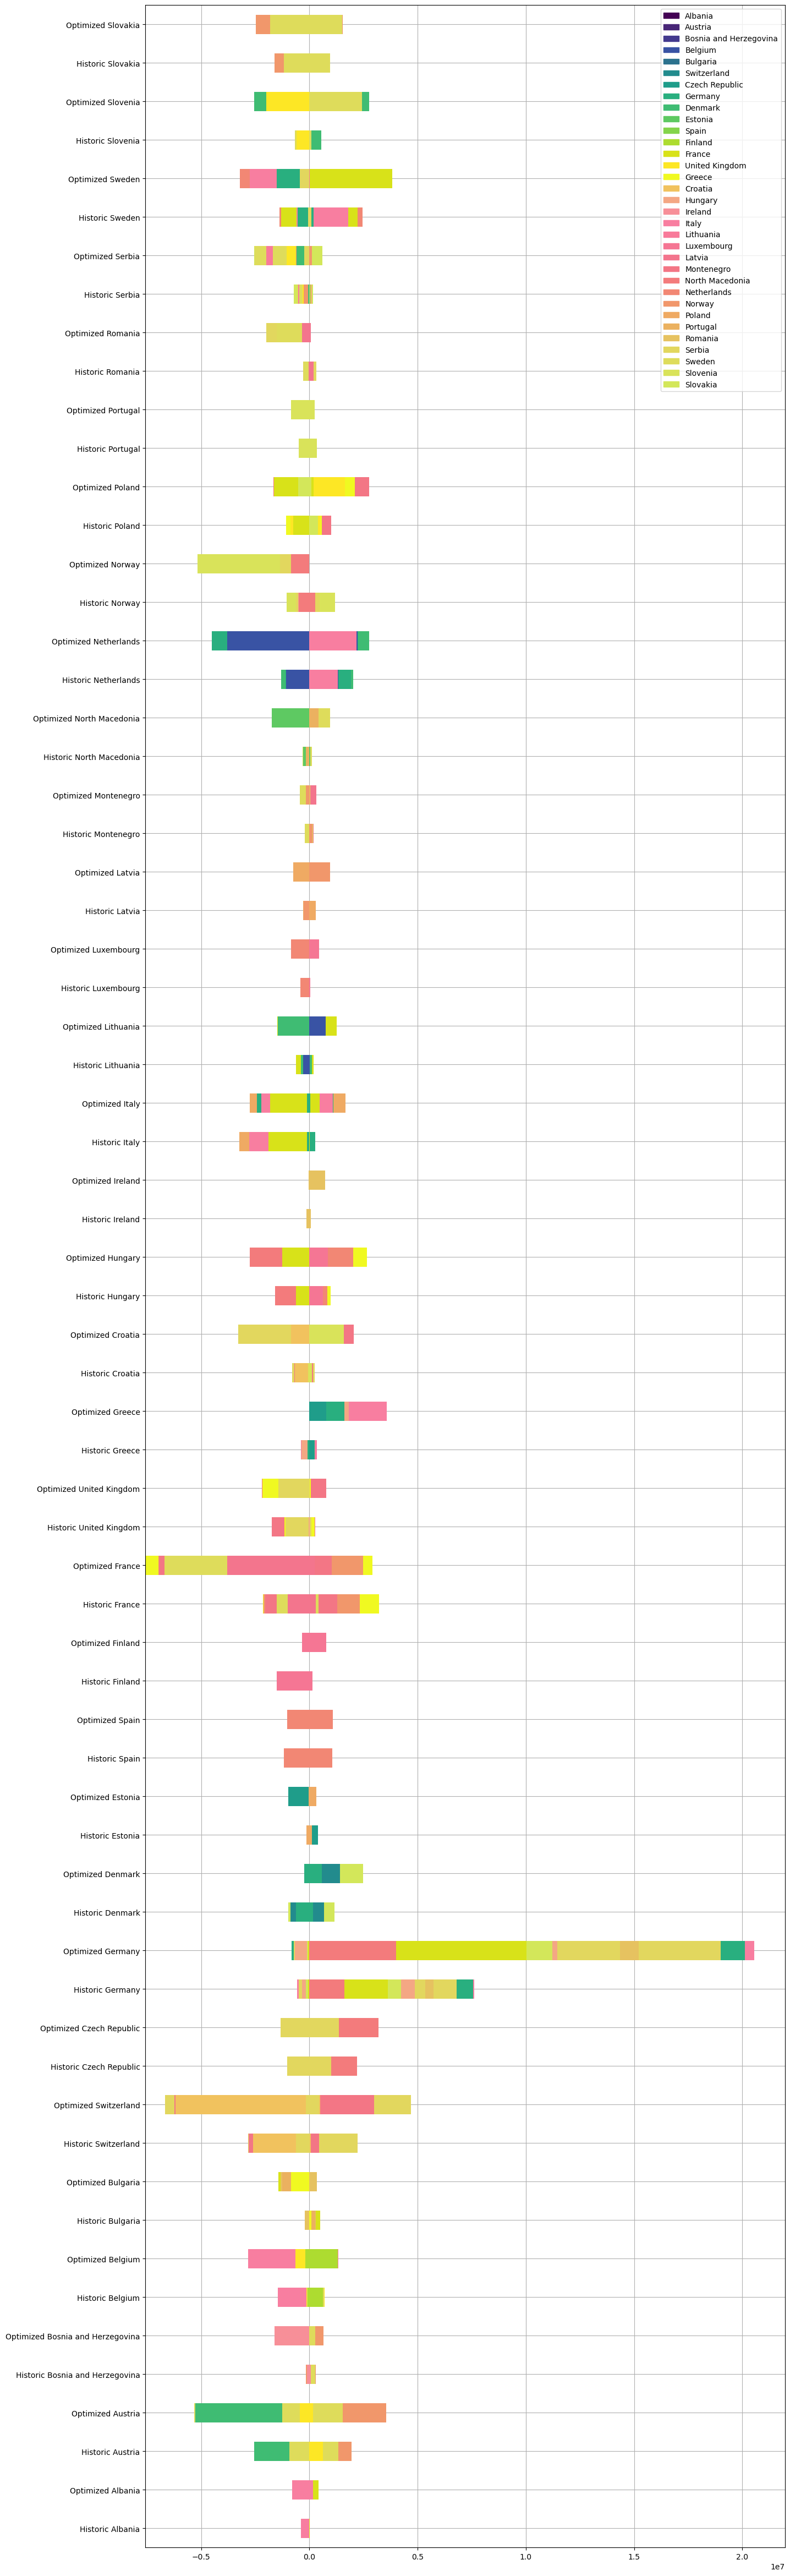

In [182]:
cross_border_bar([historic,optimized],['Historic','Optimized'])

/tmp/ipykernel_3230/771548331.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(2,1,figsize=(15,10))


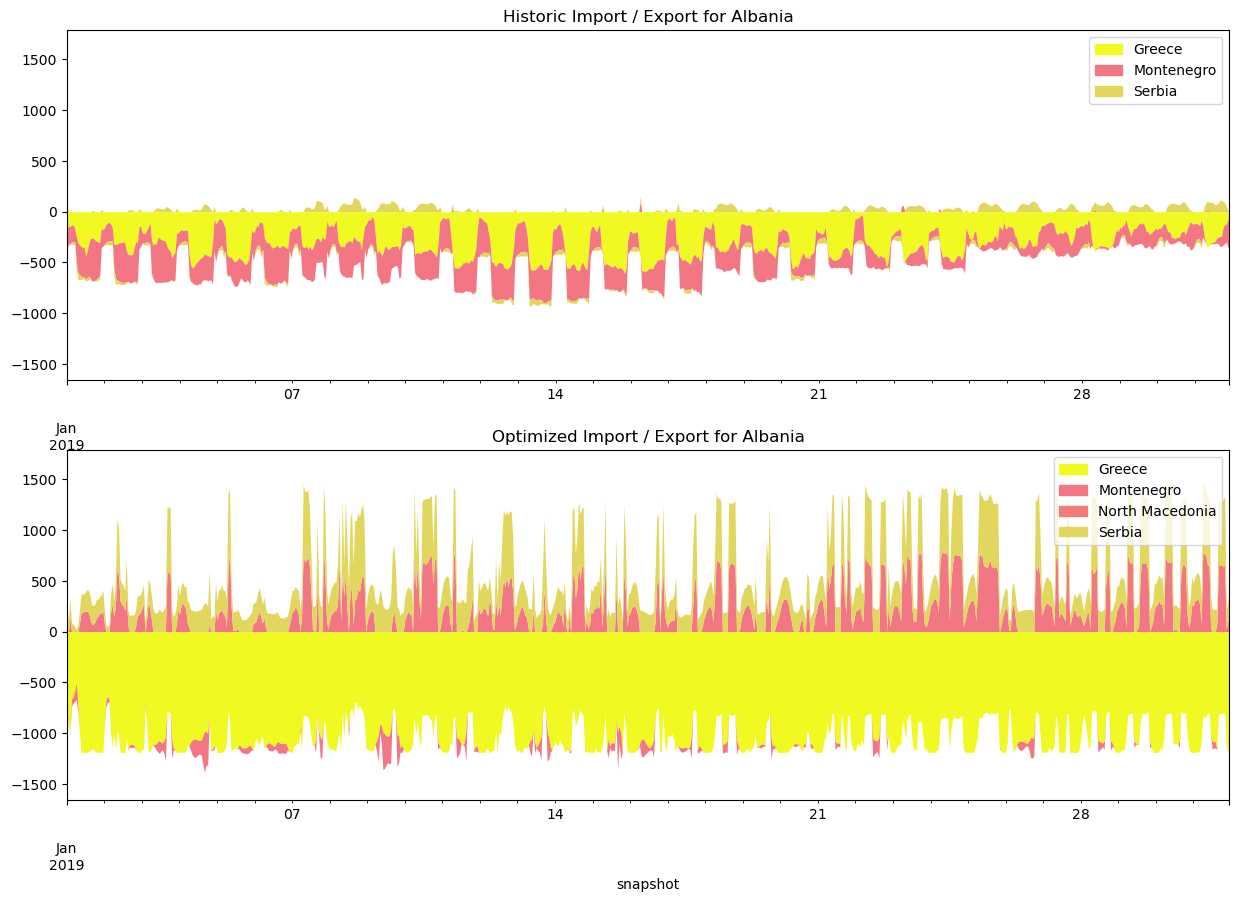

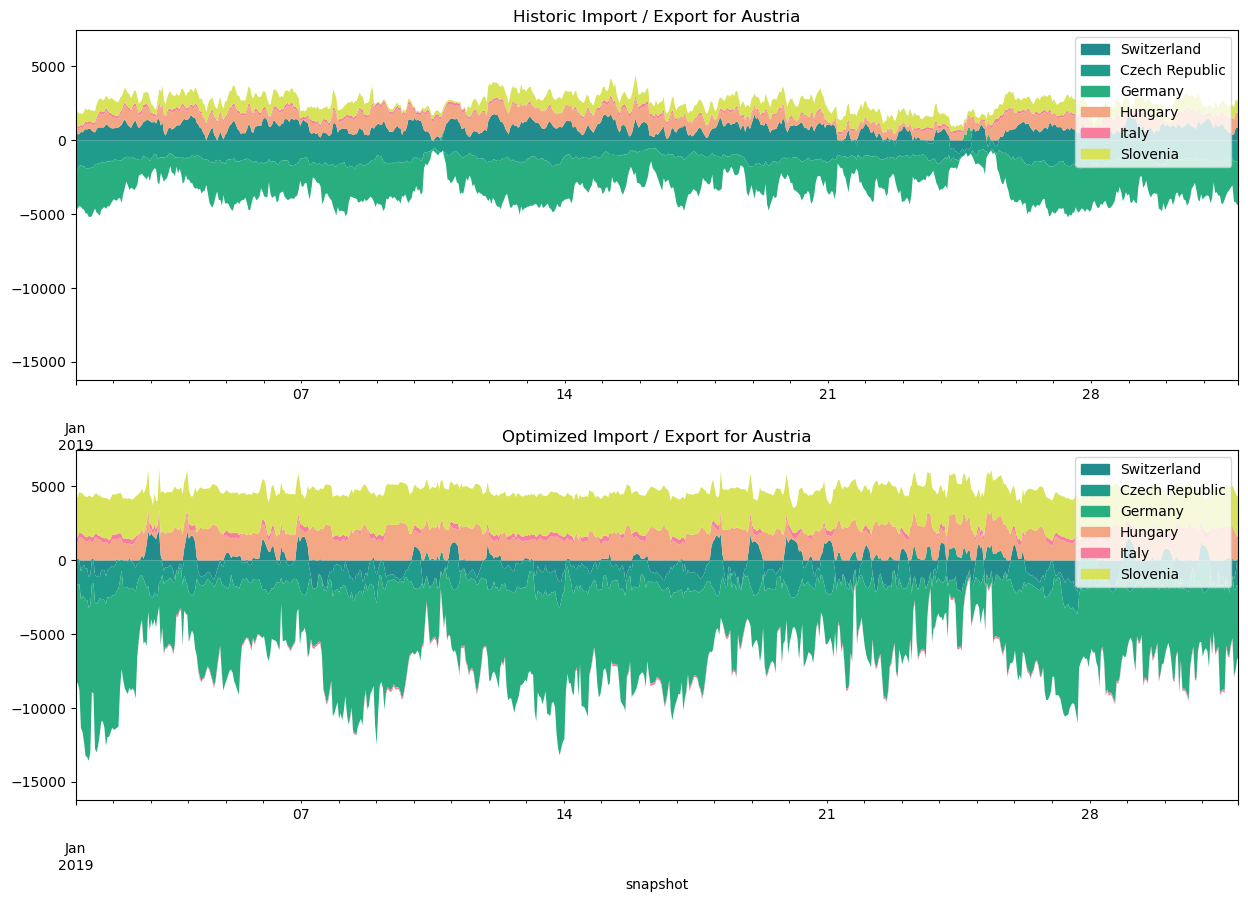

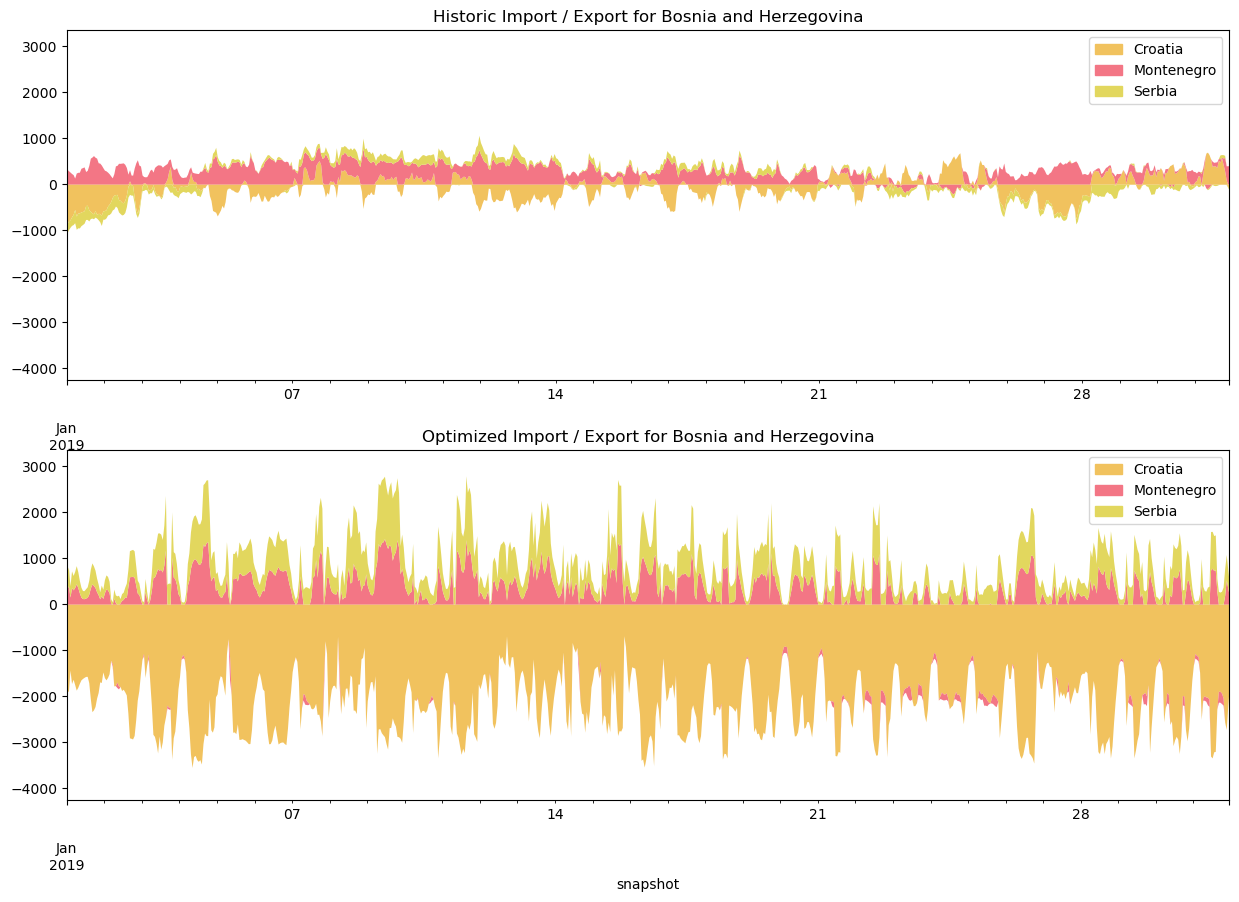

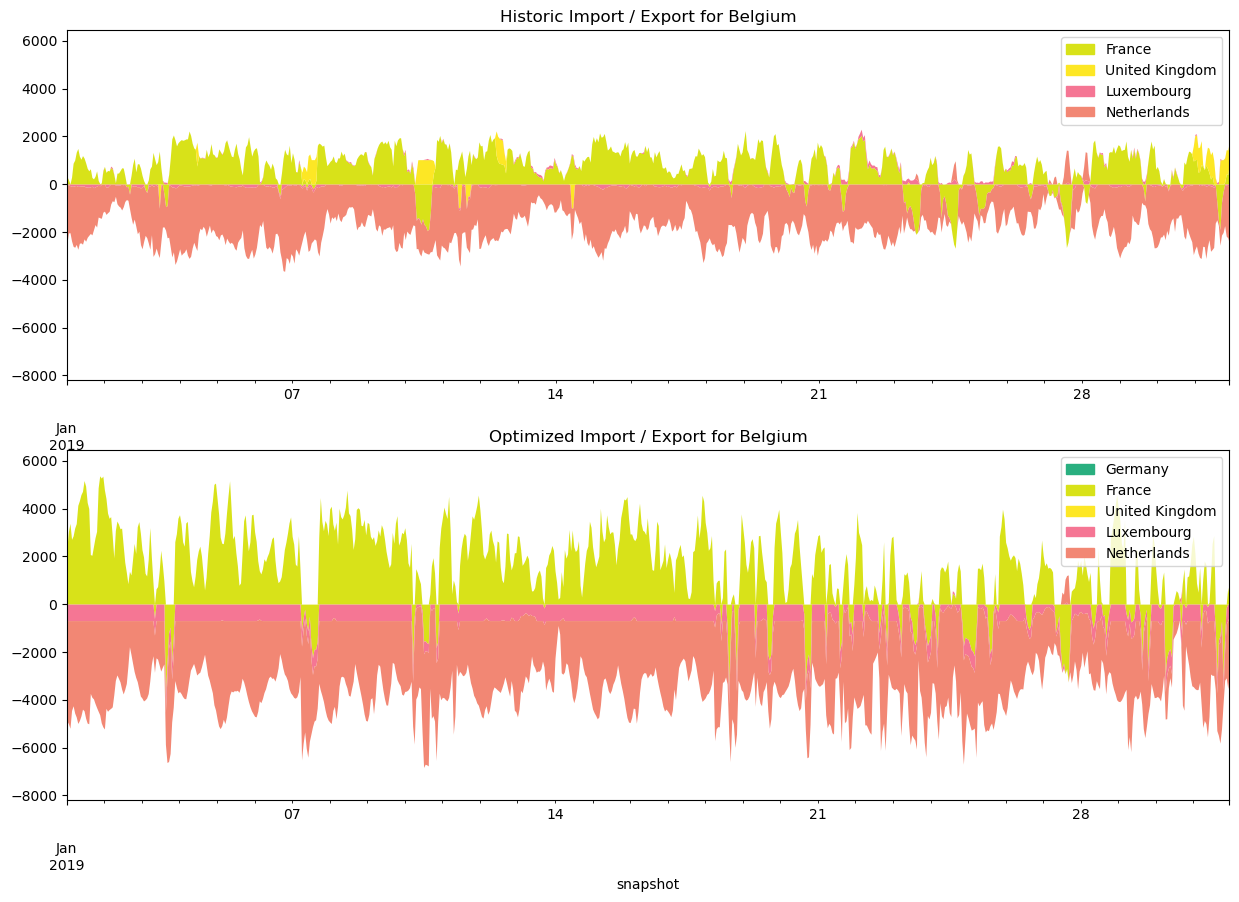

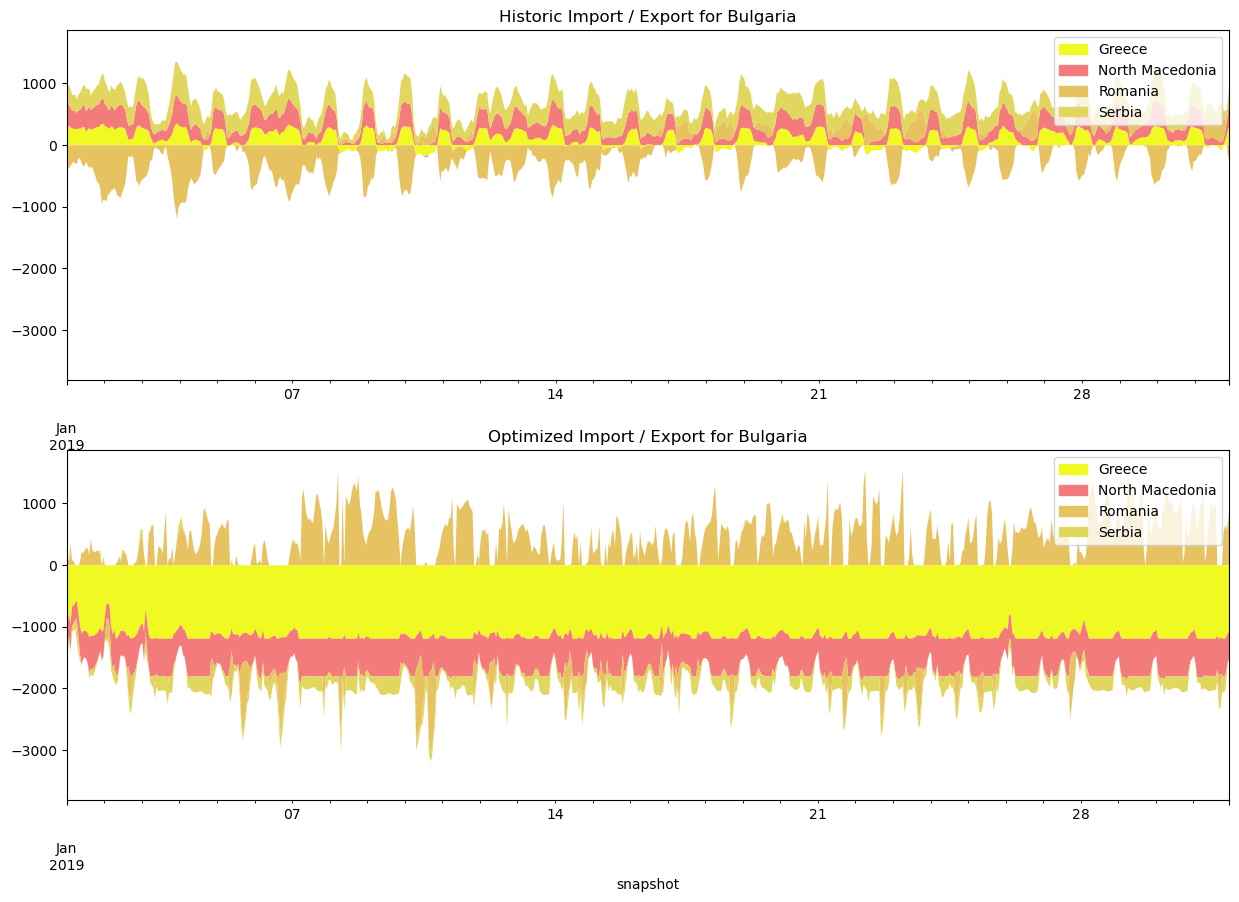

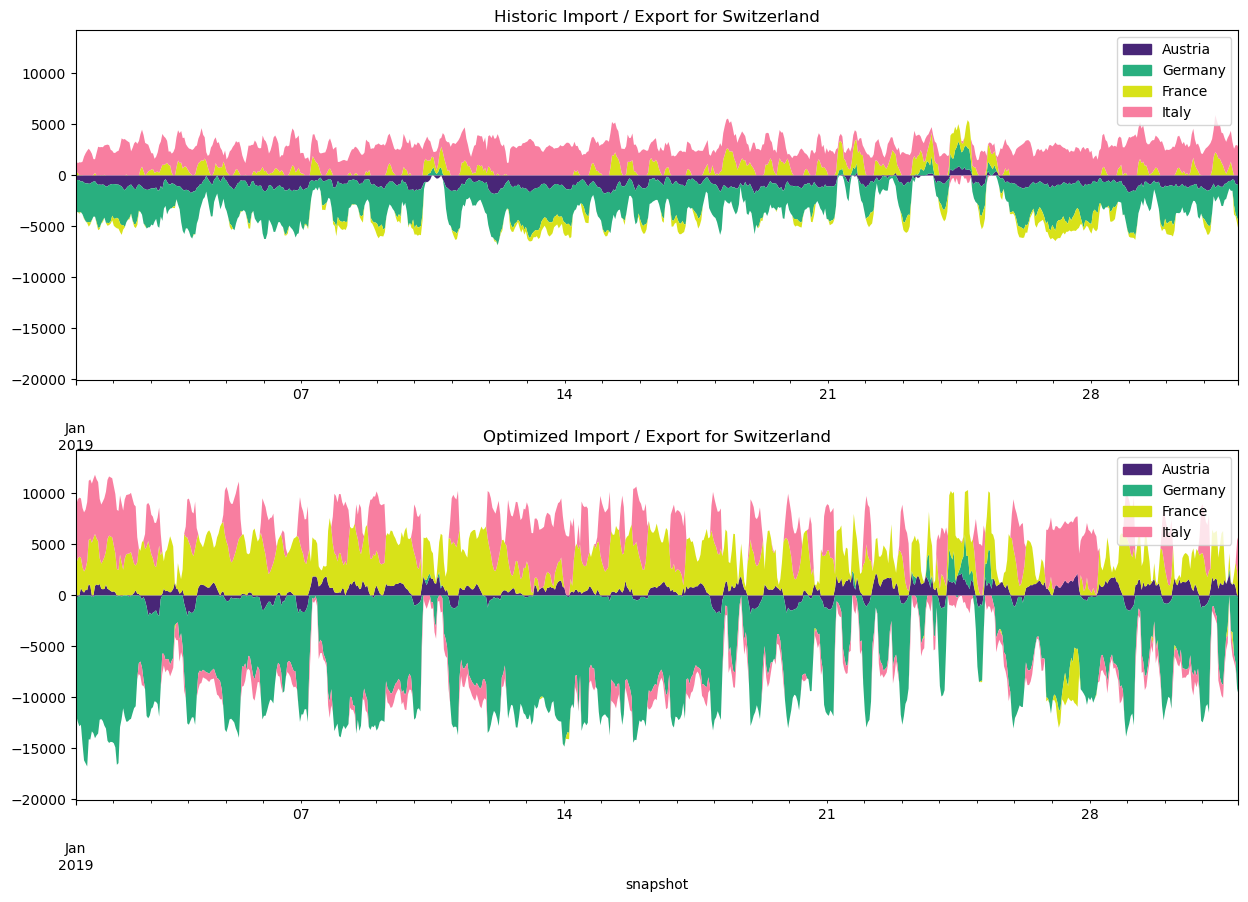

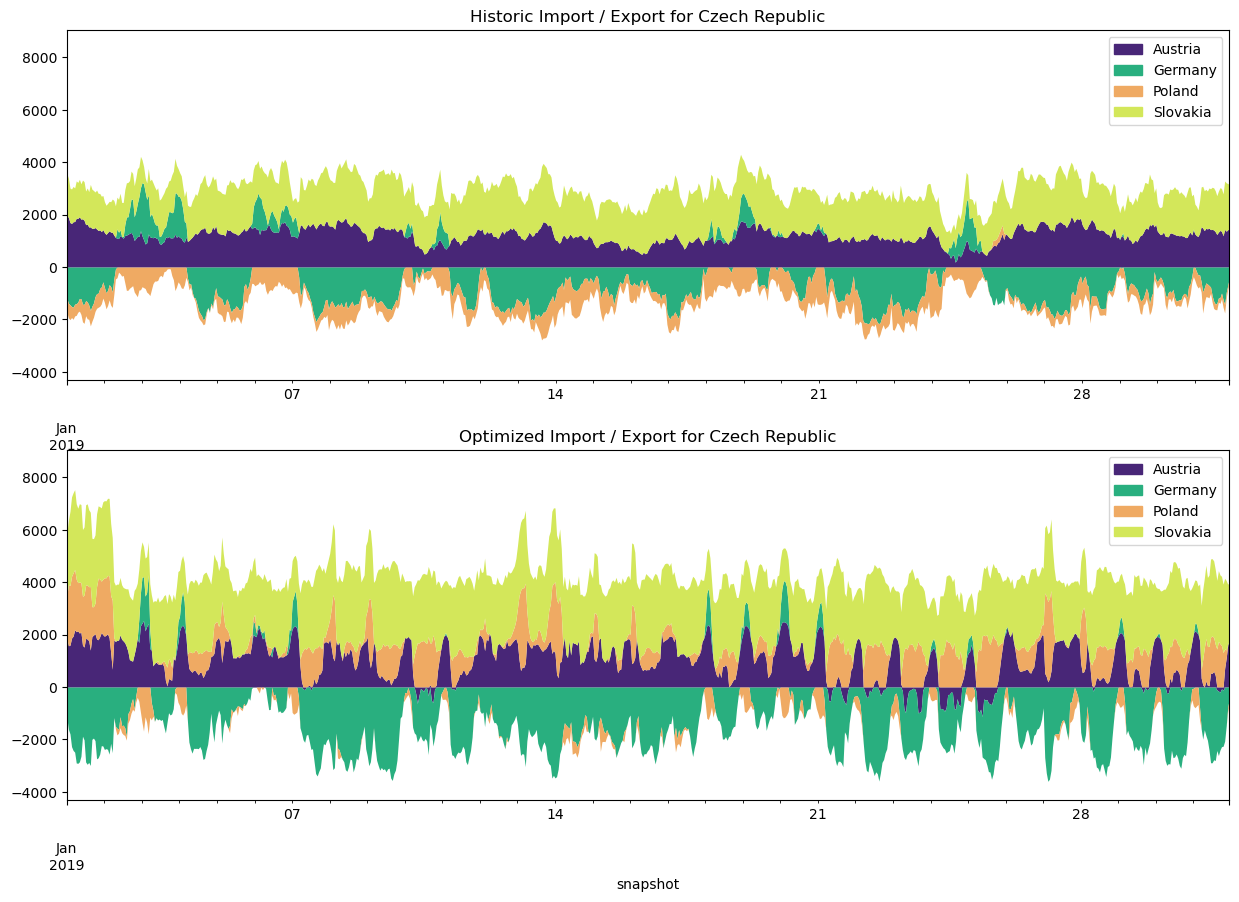

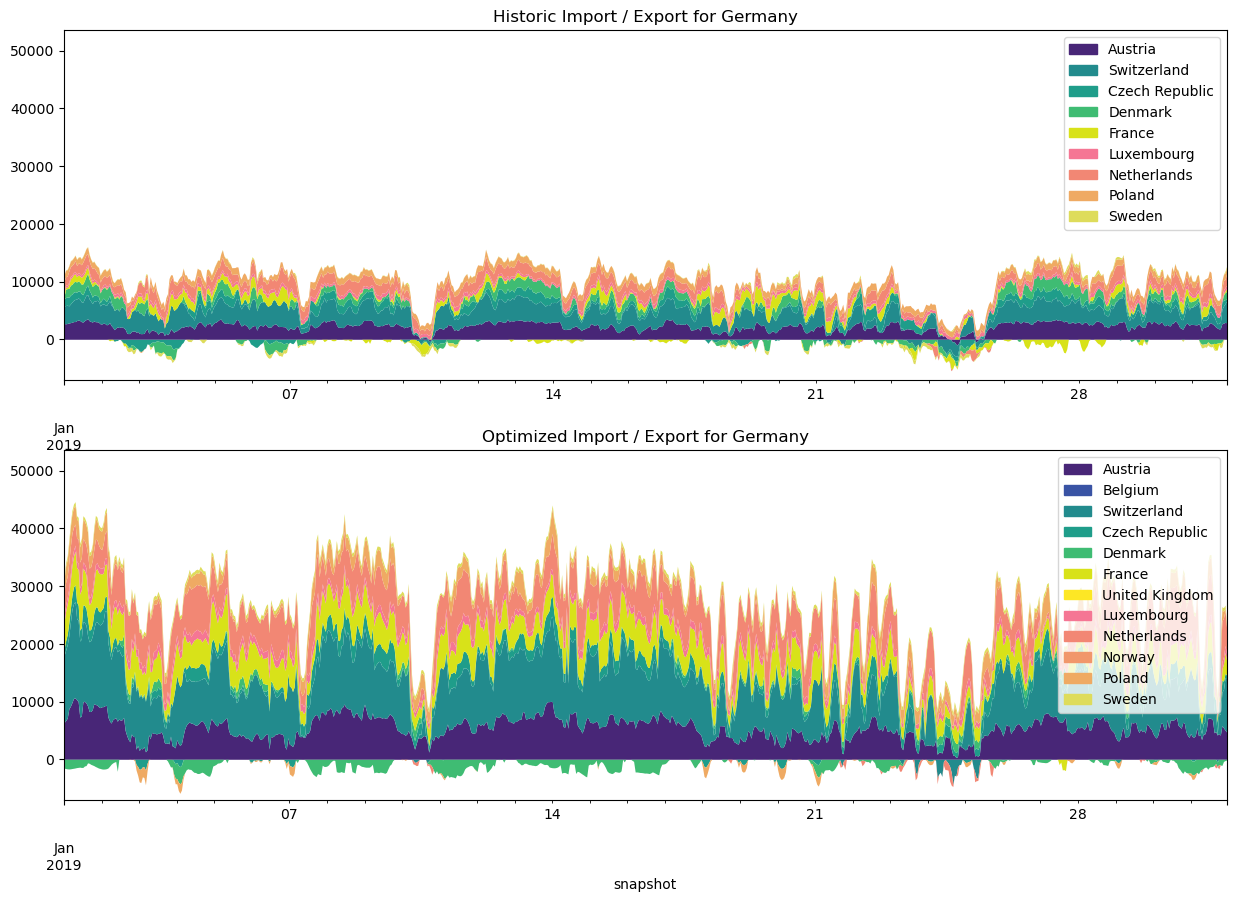

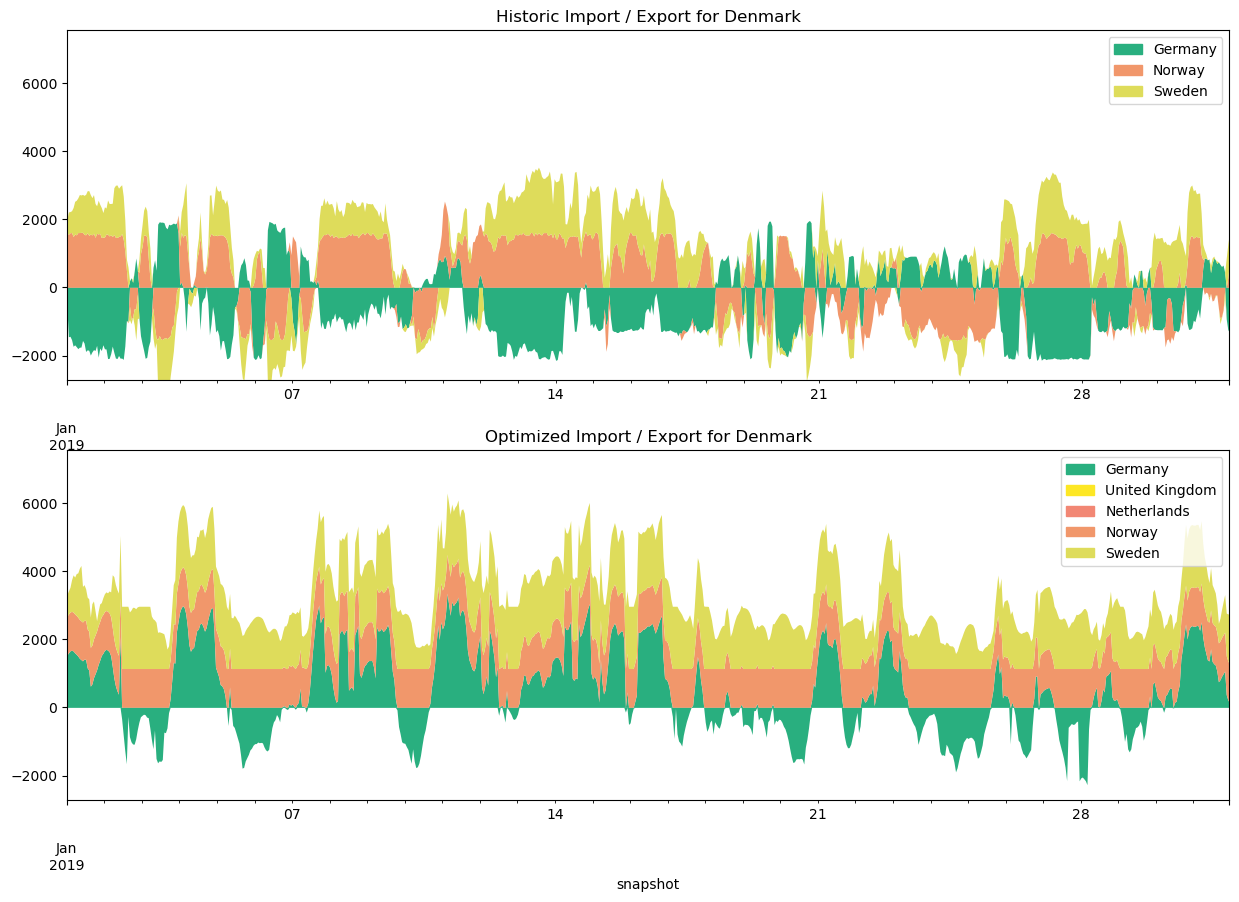

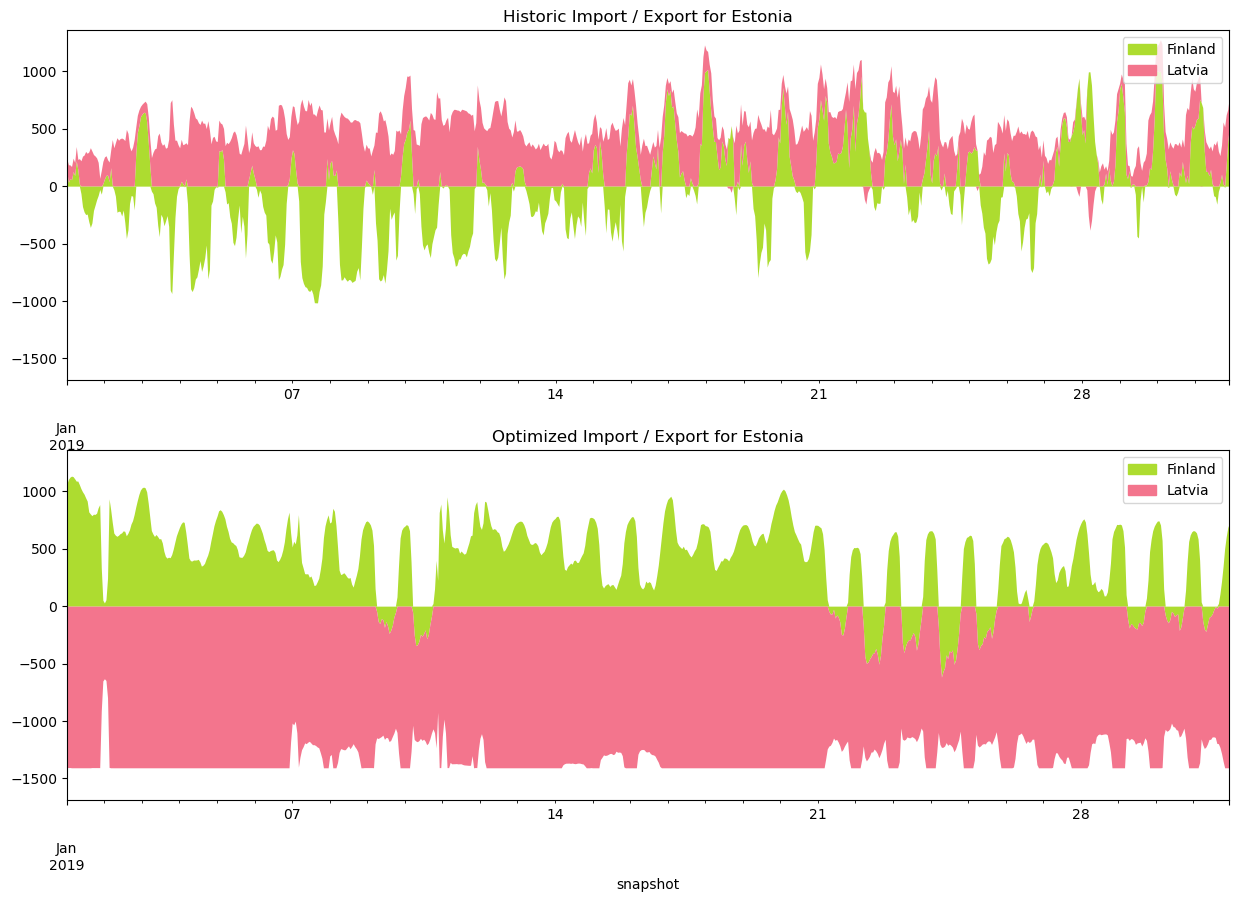

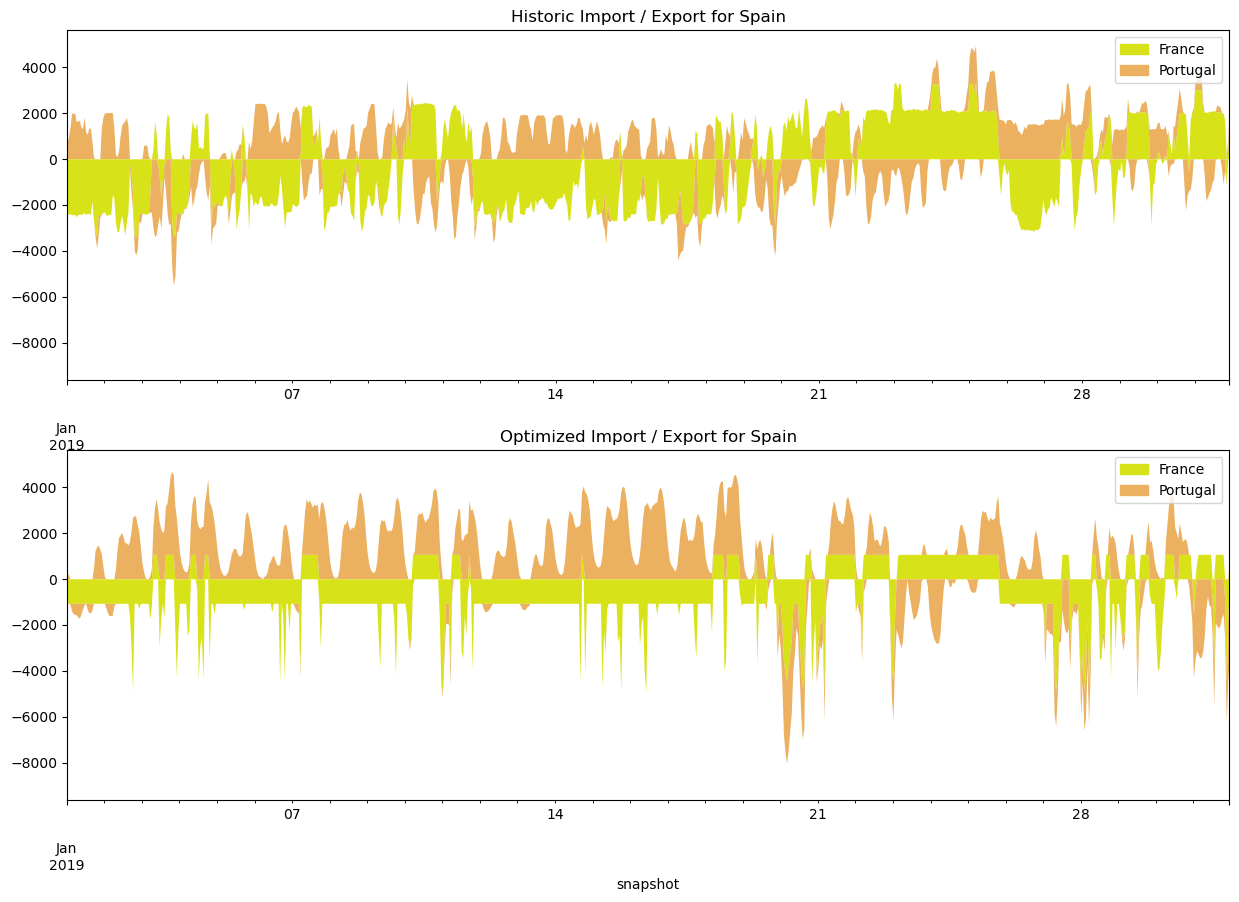

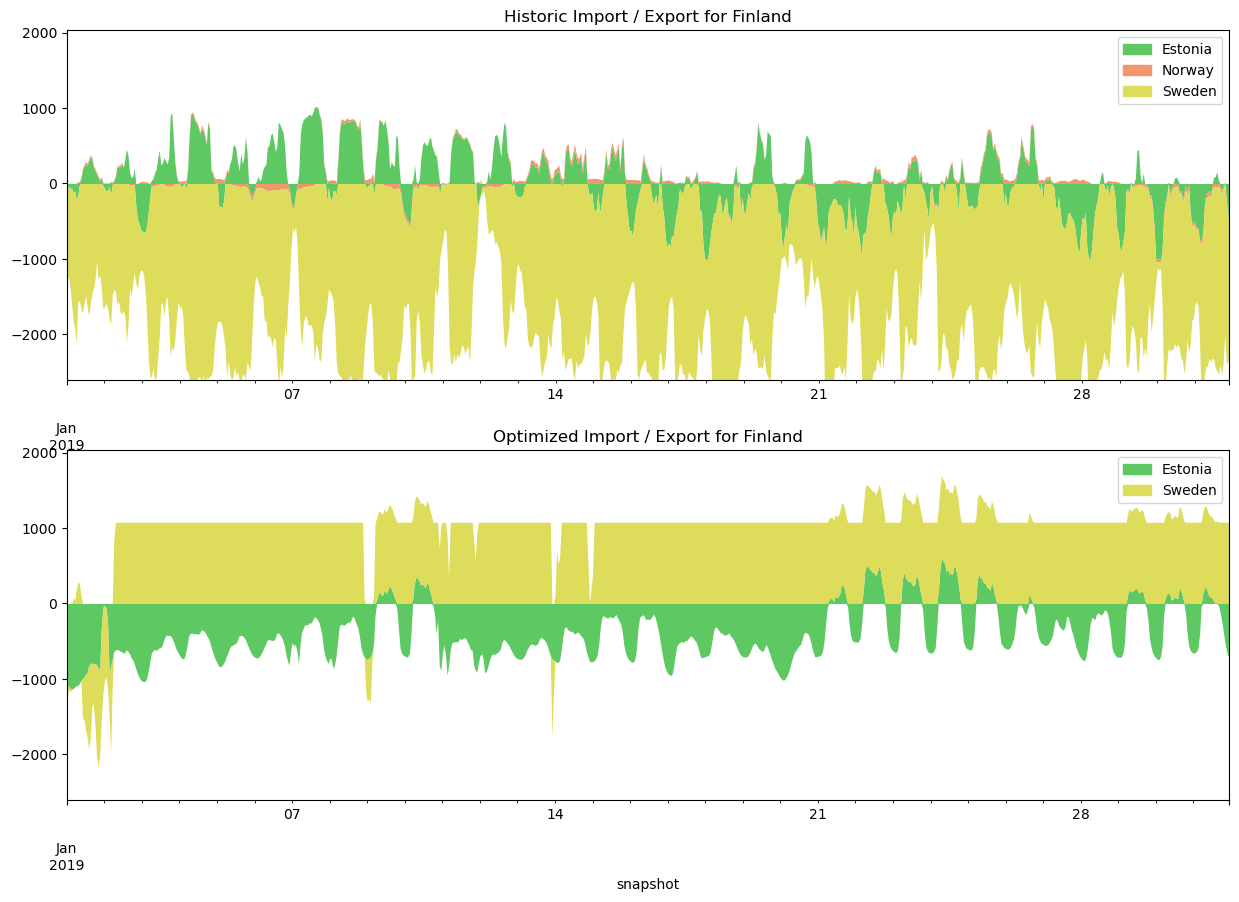

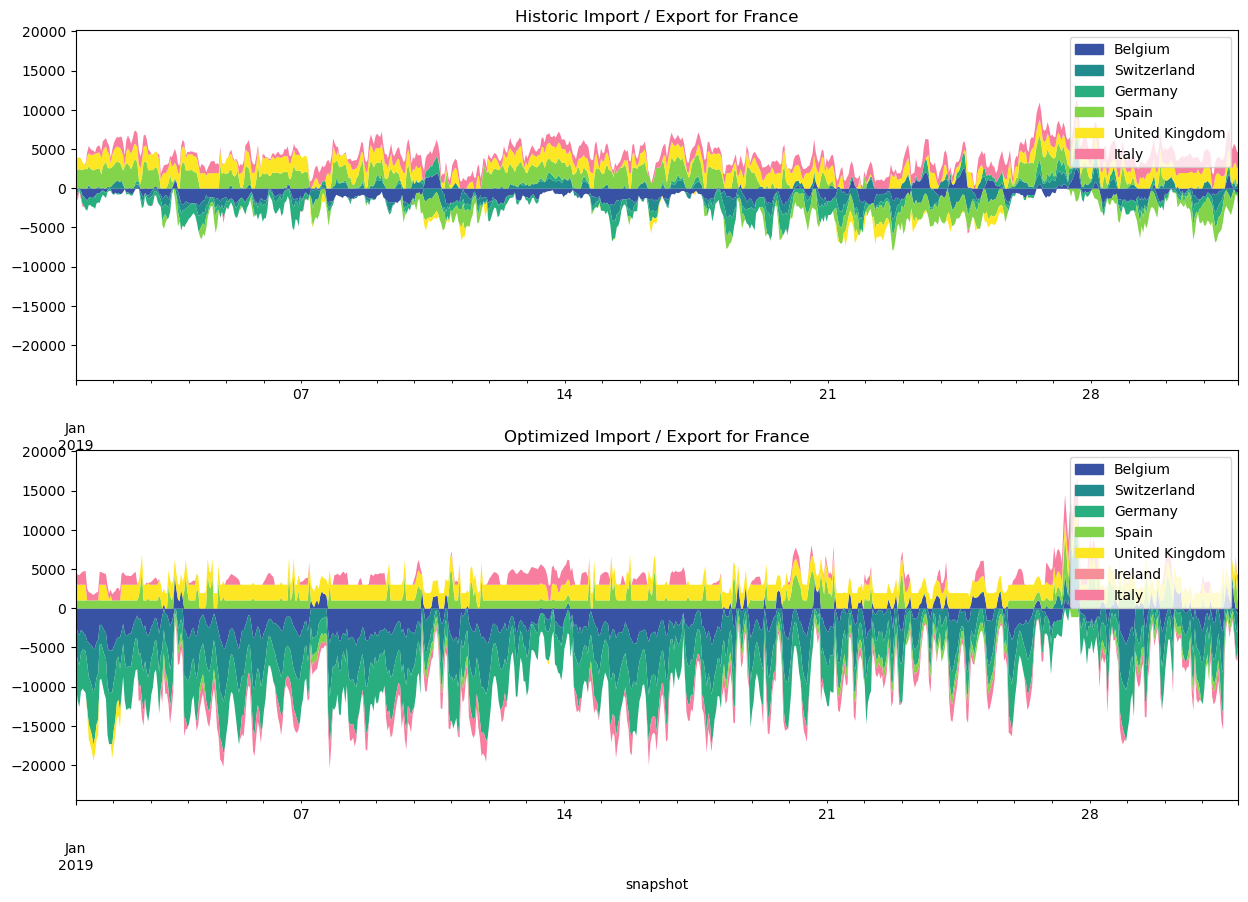

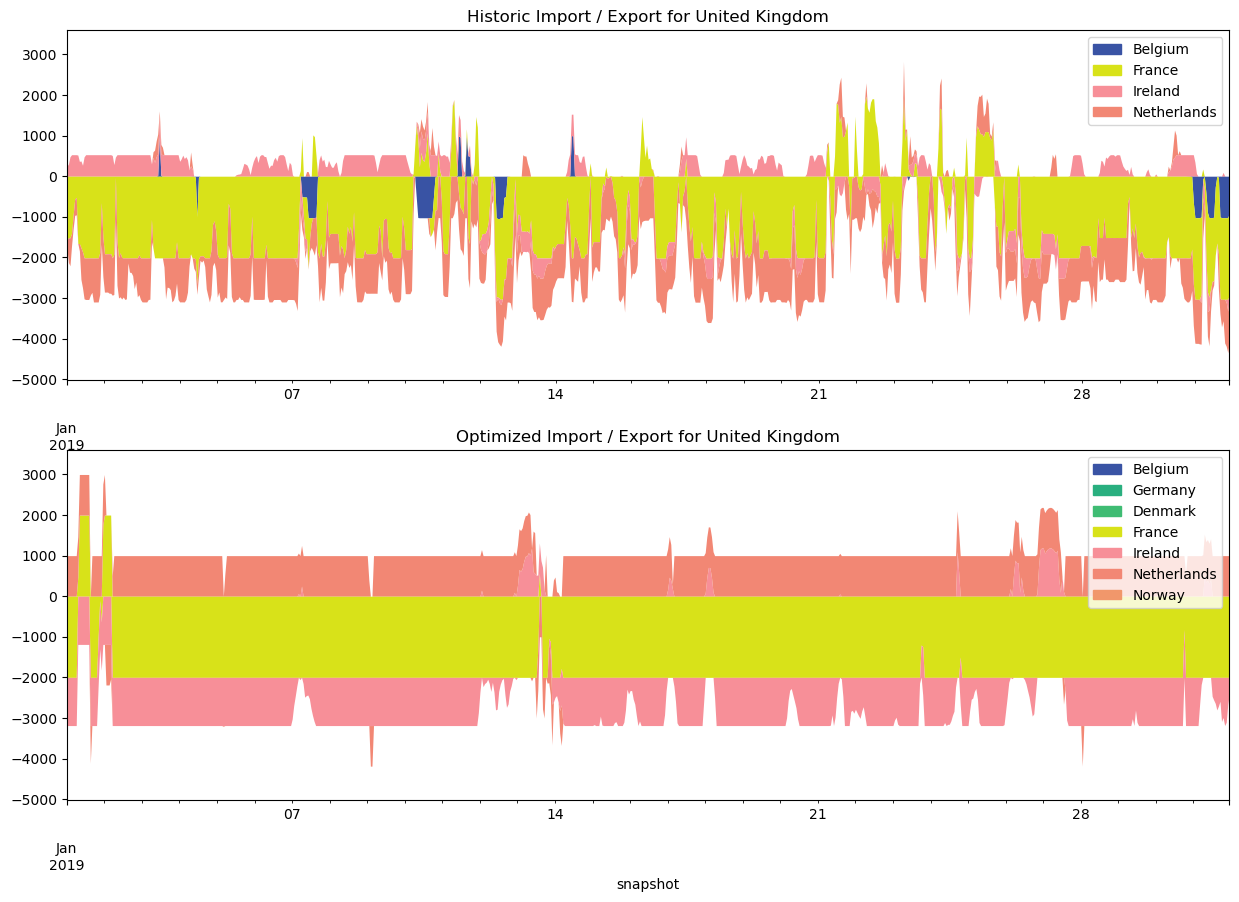

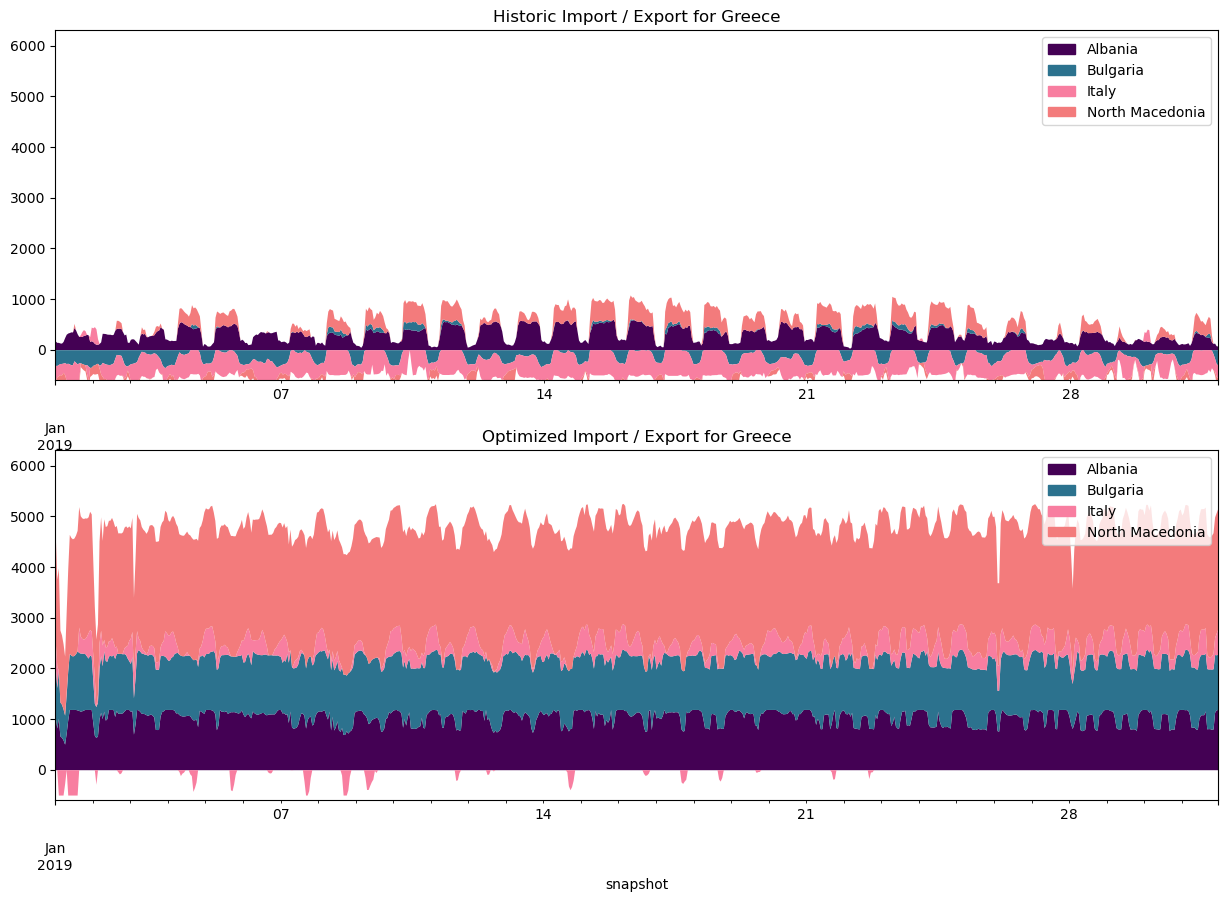

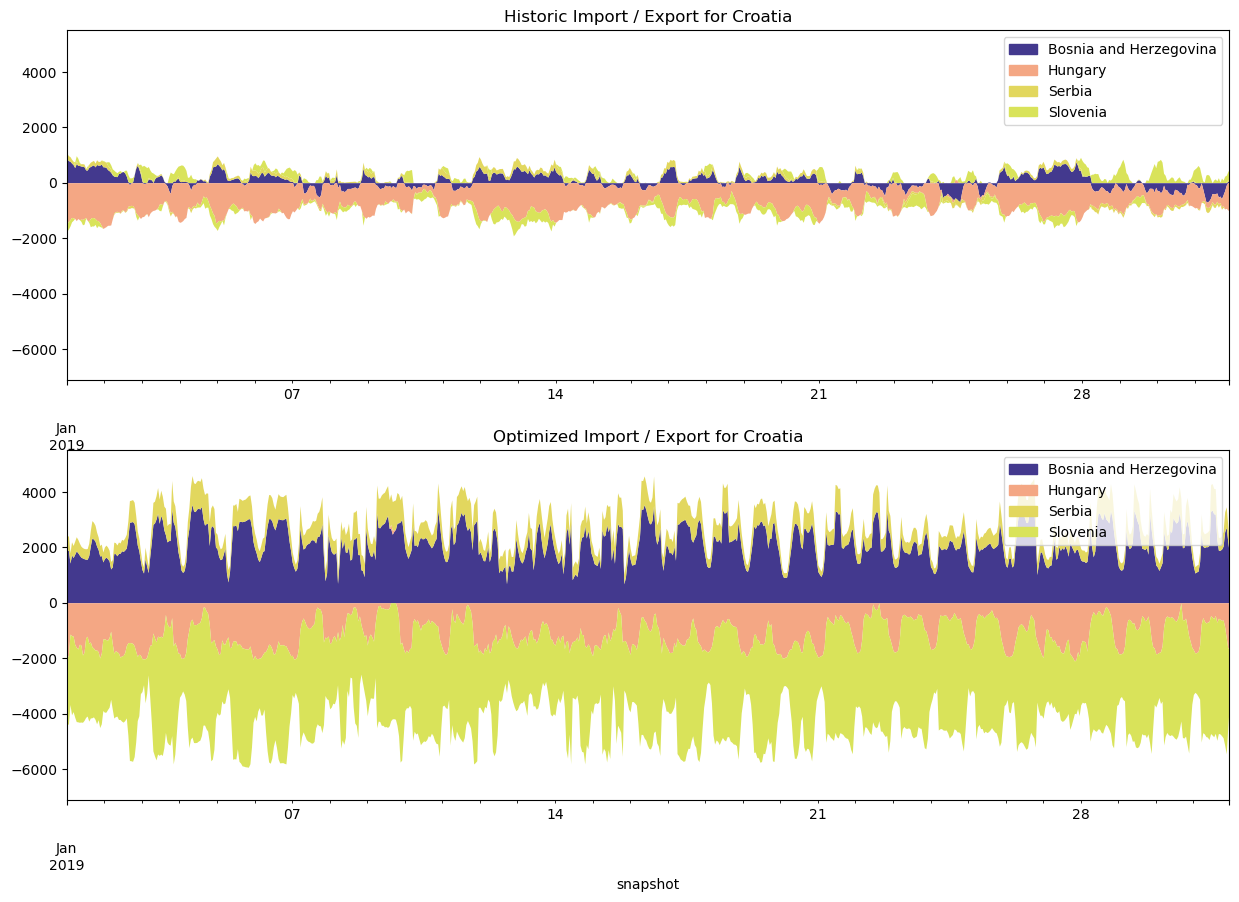

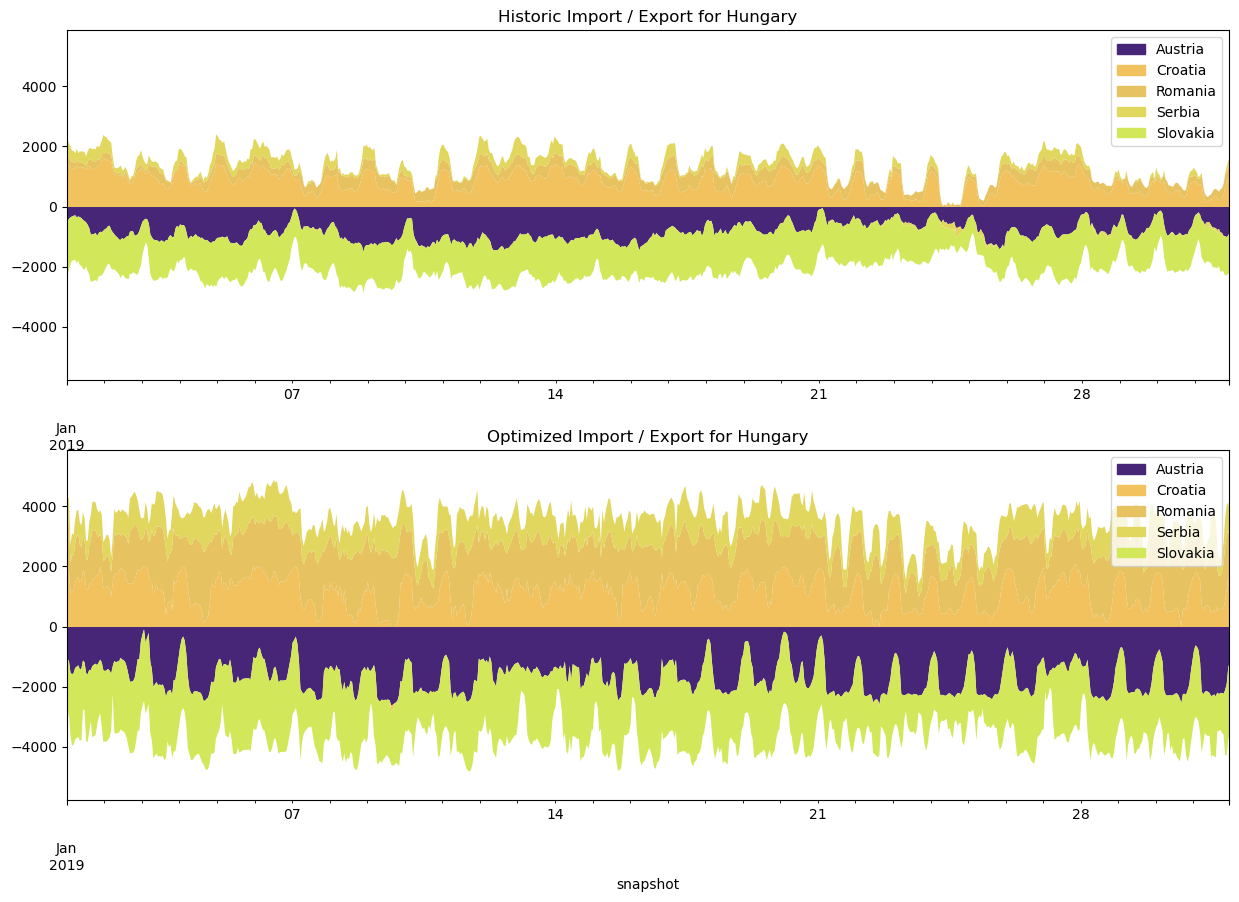

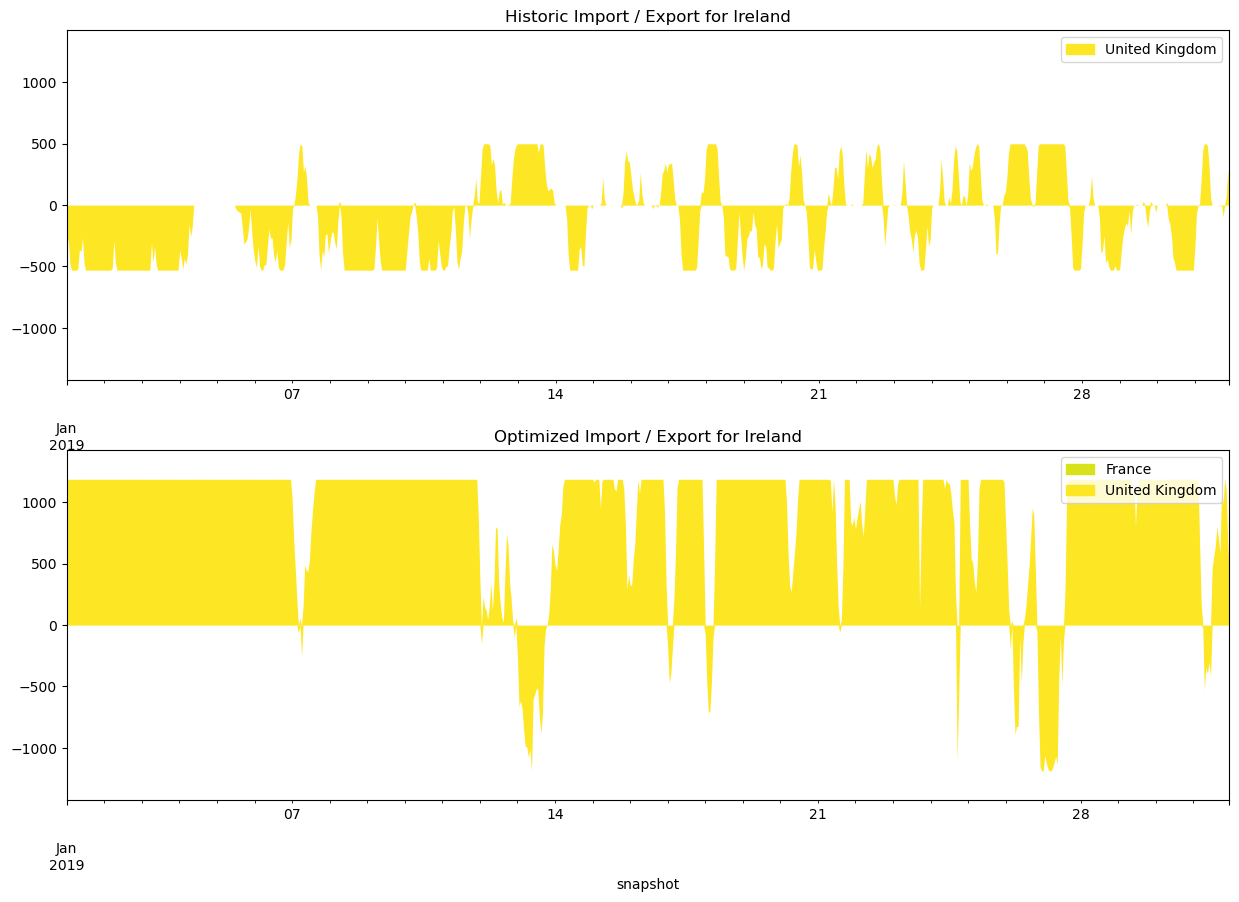

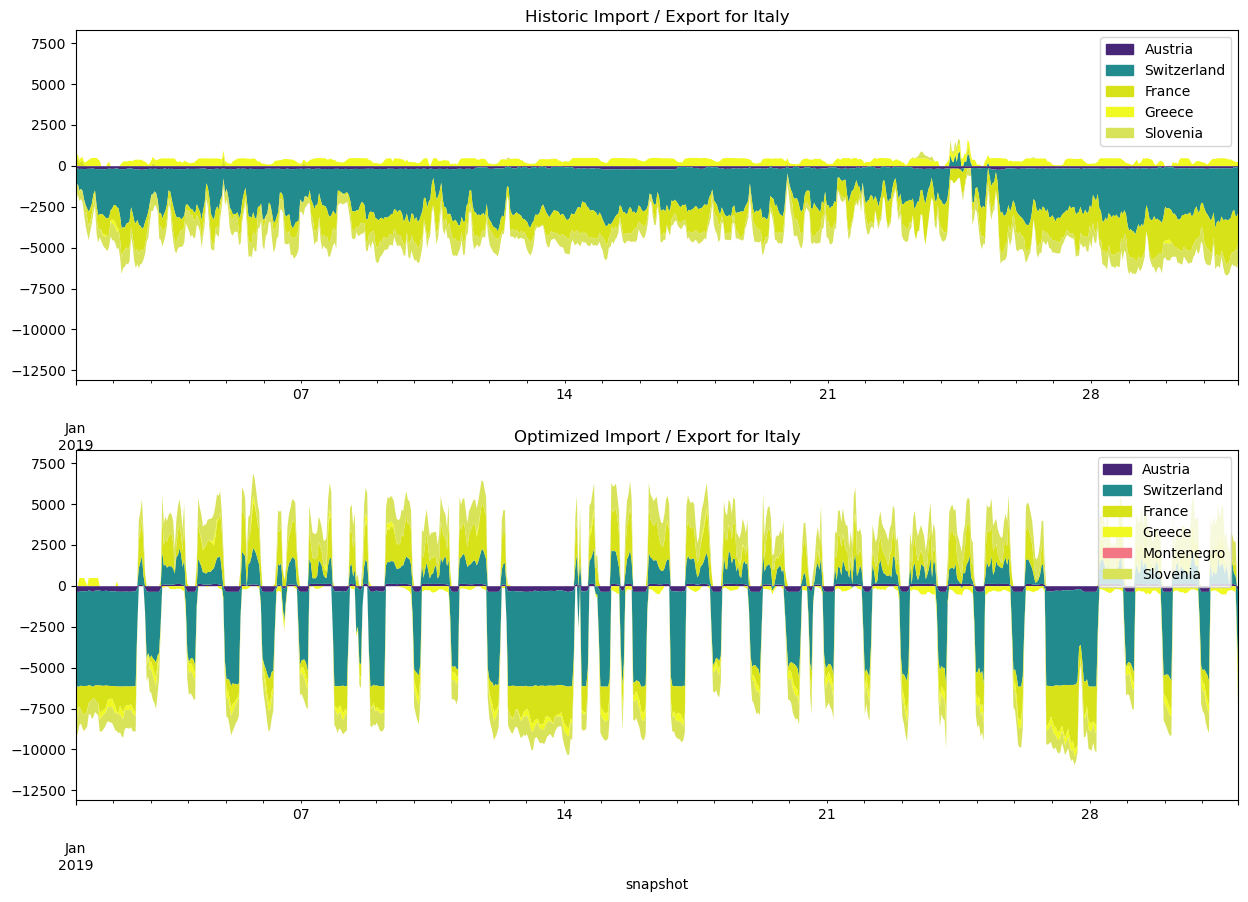

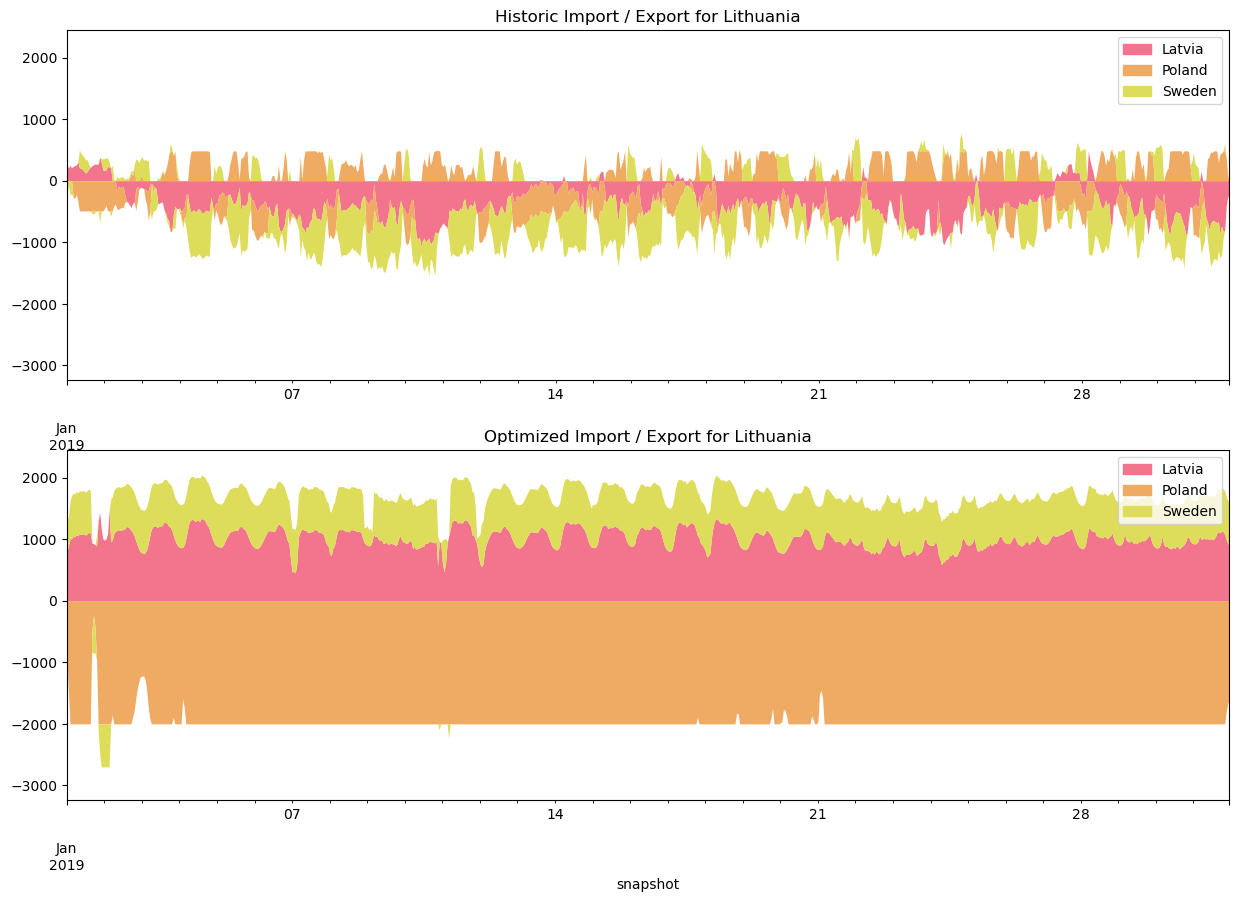

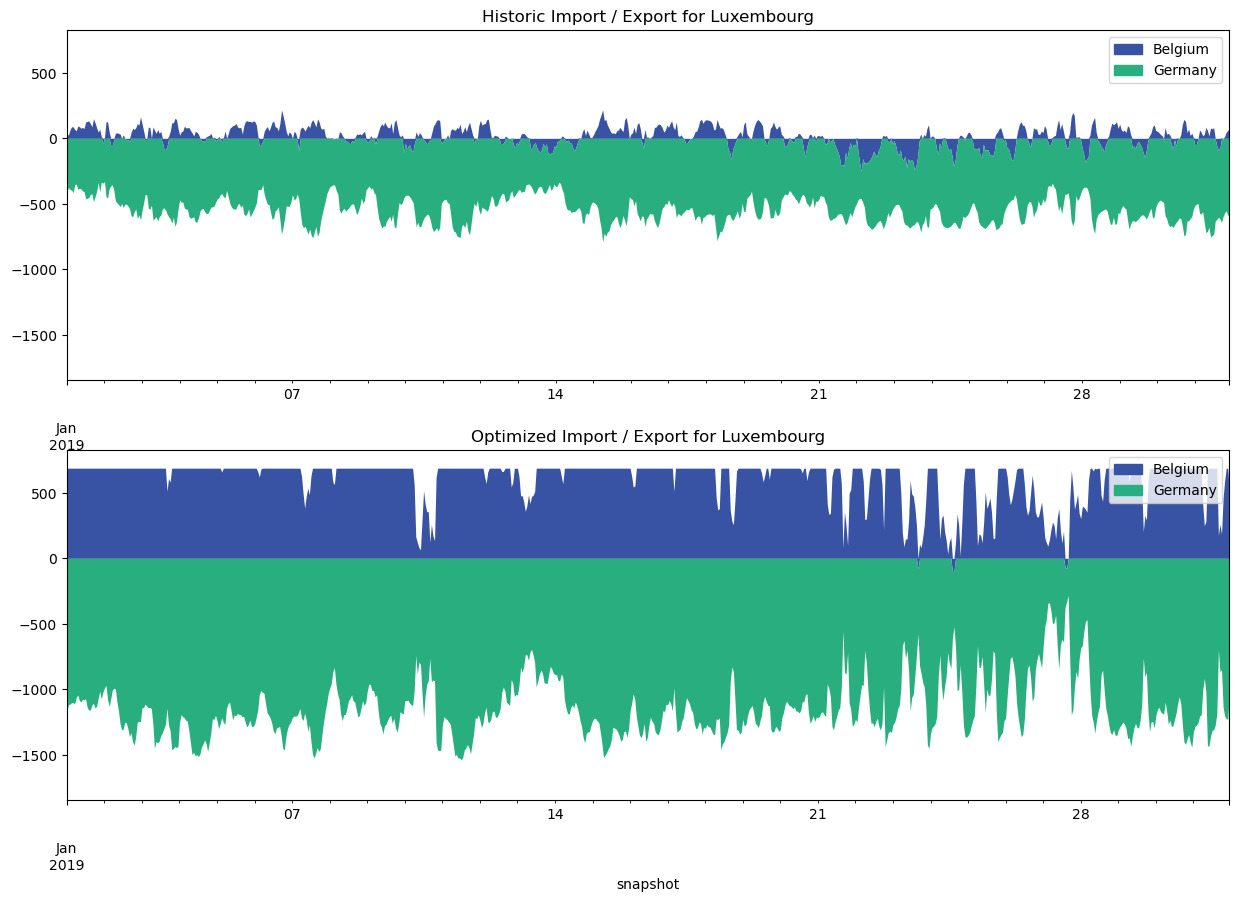

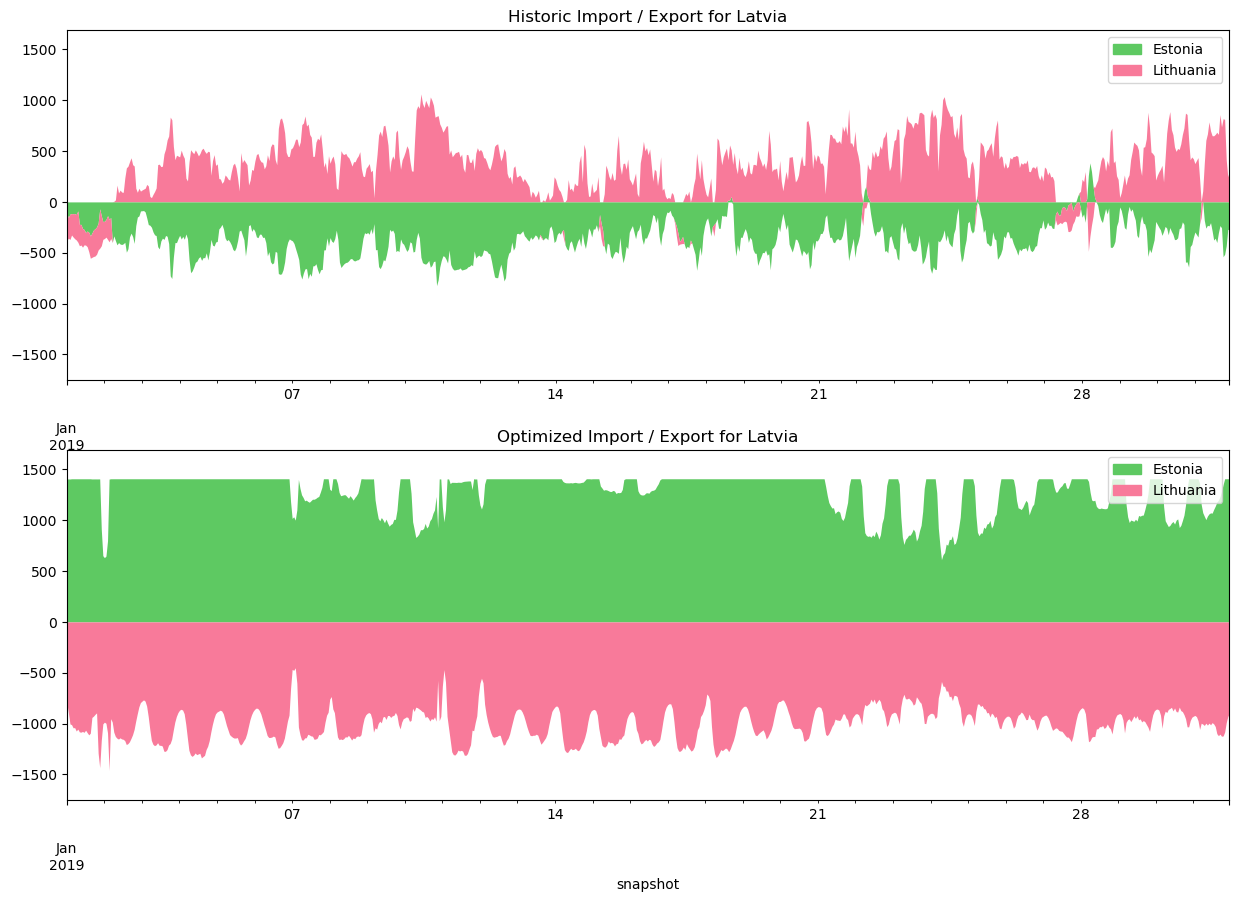

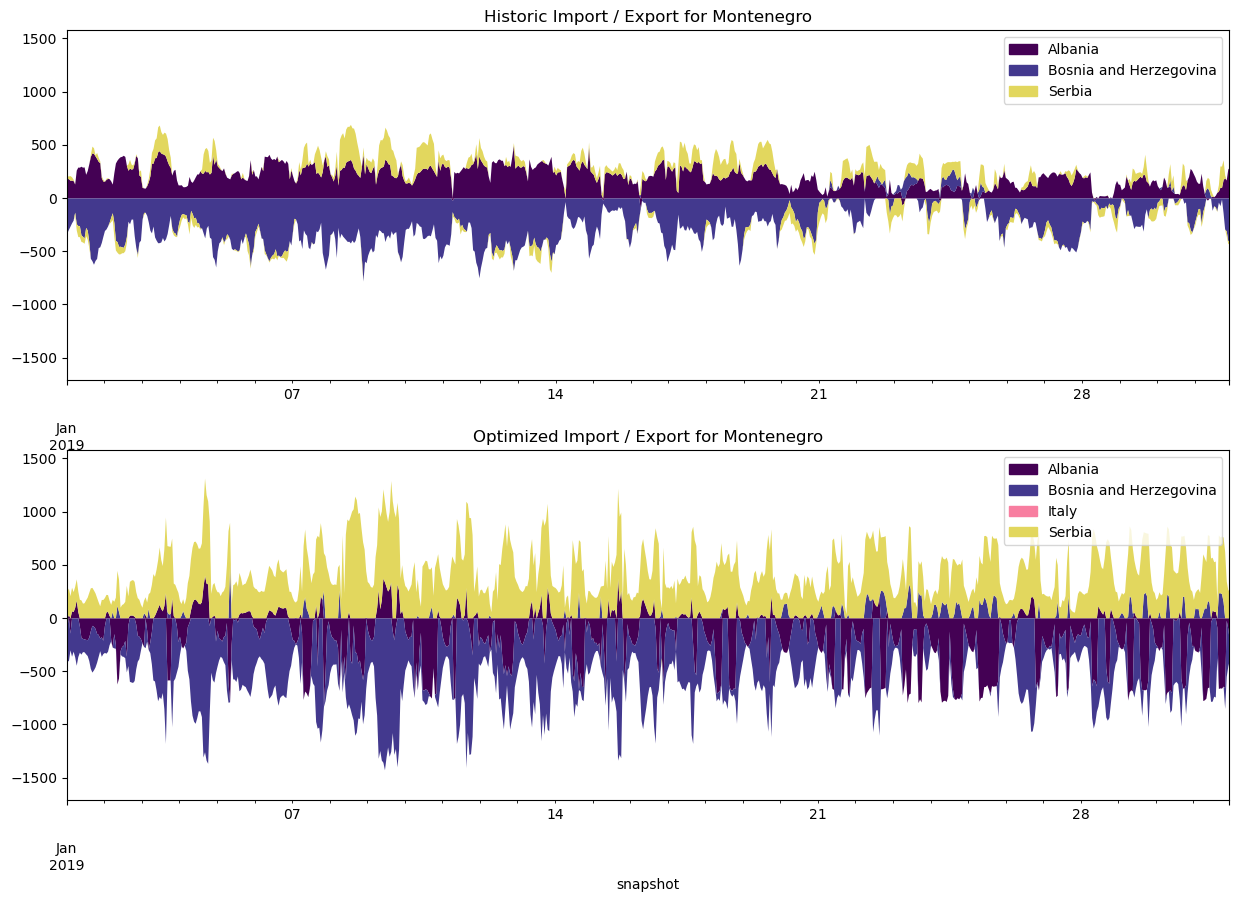

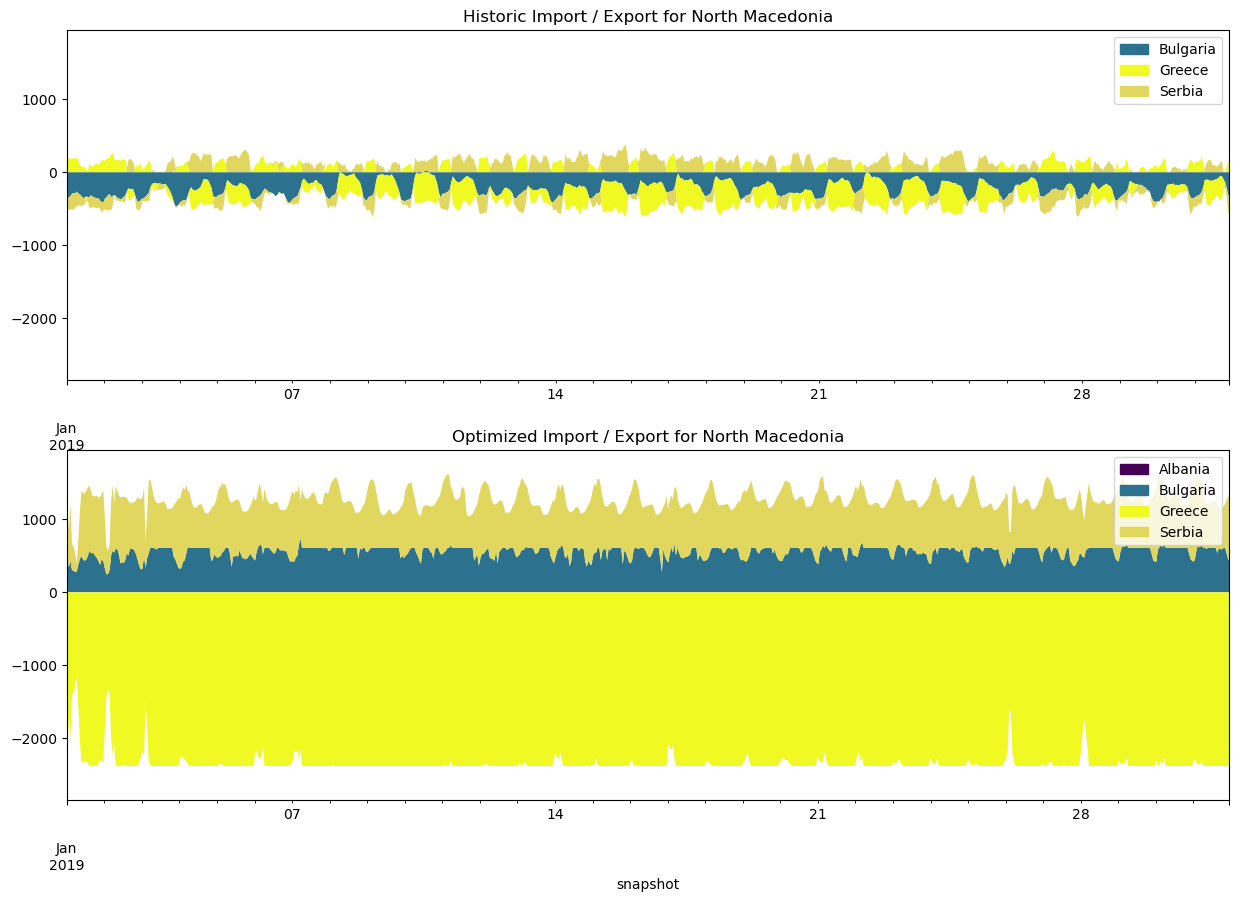

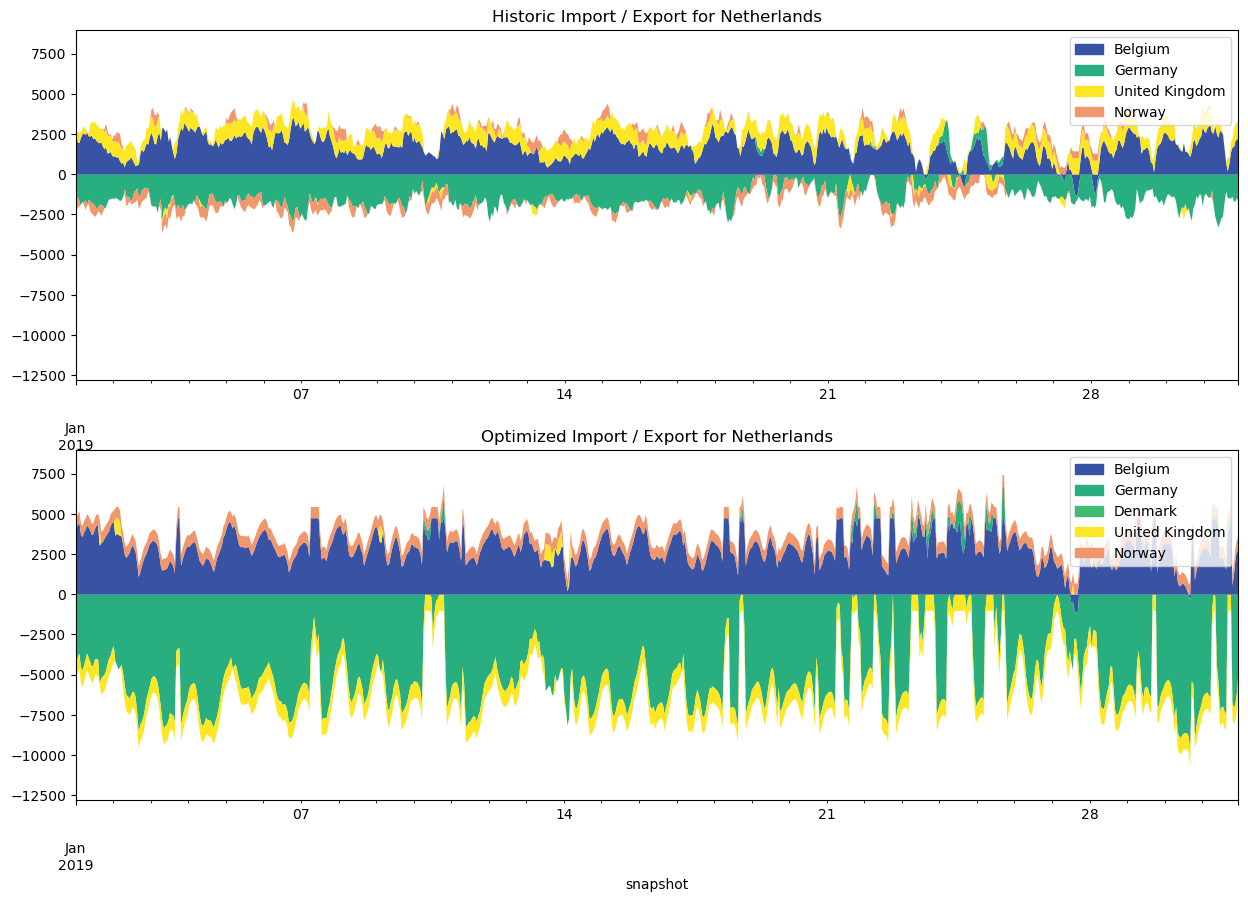

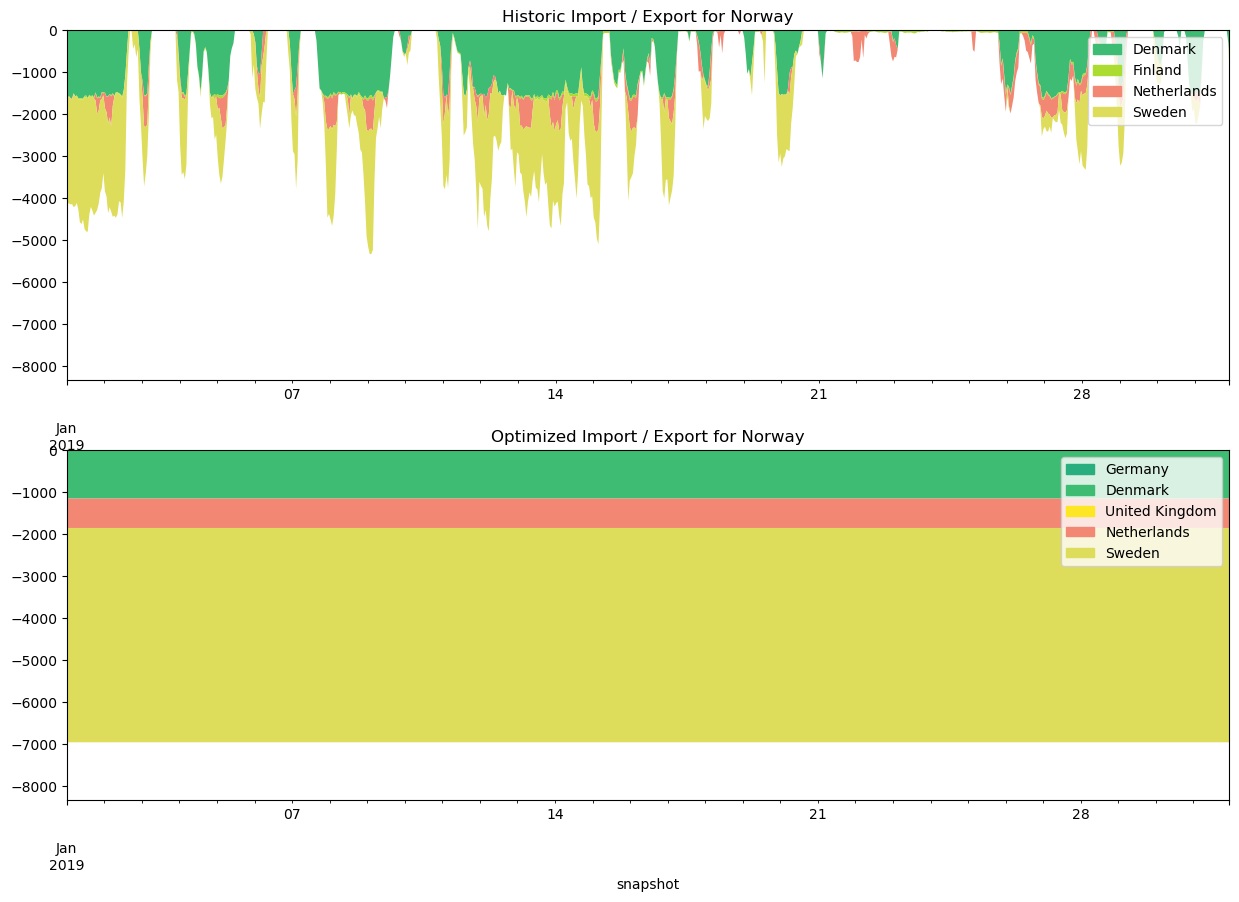

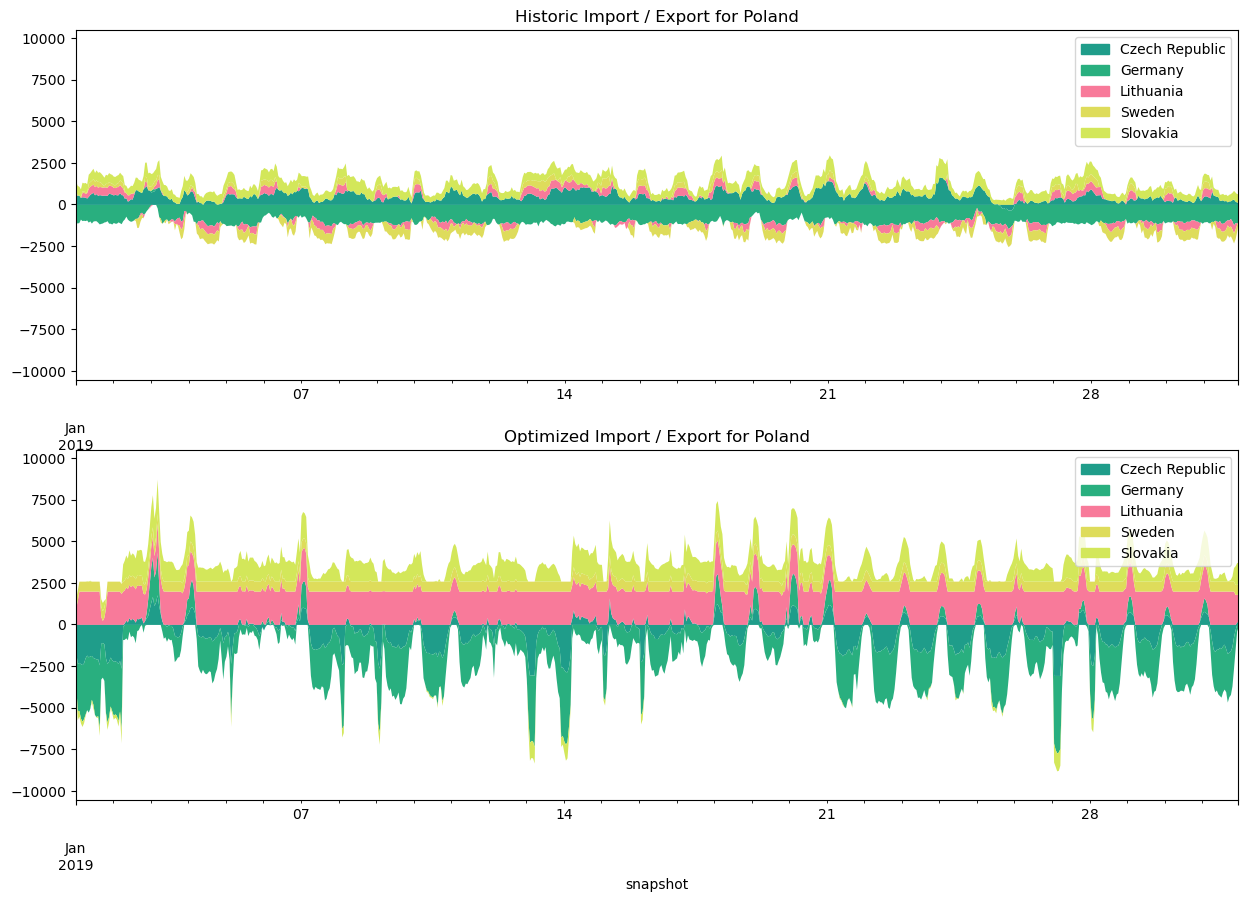

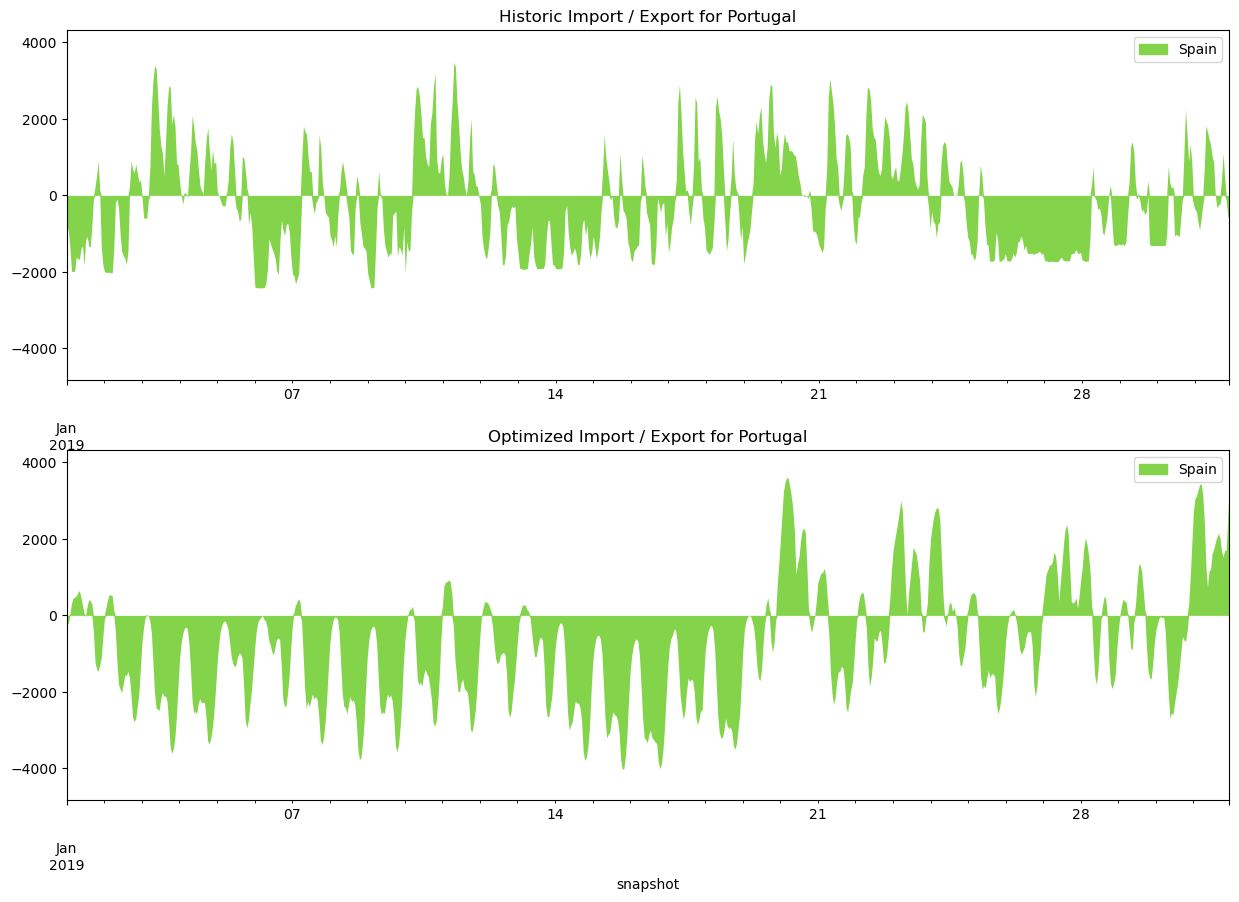

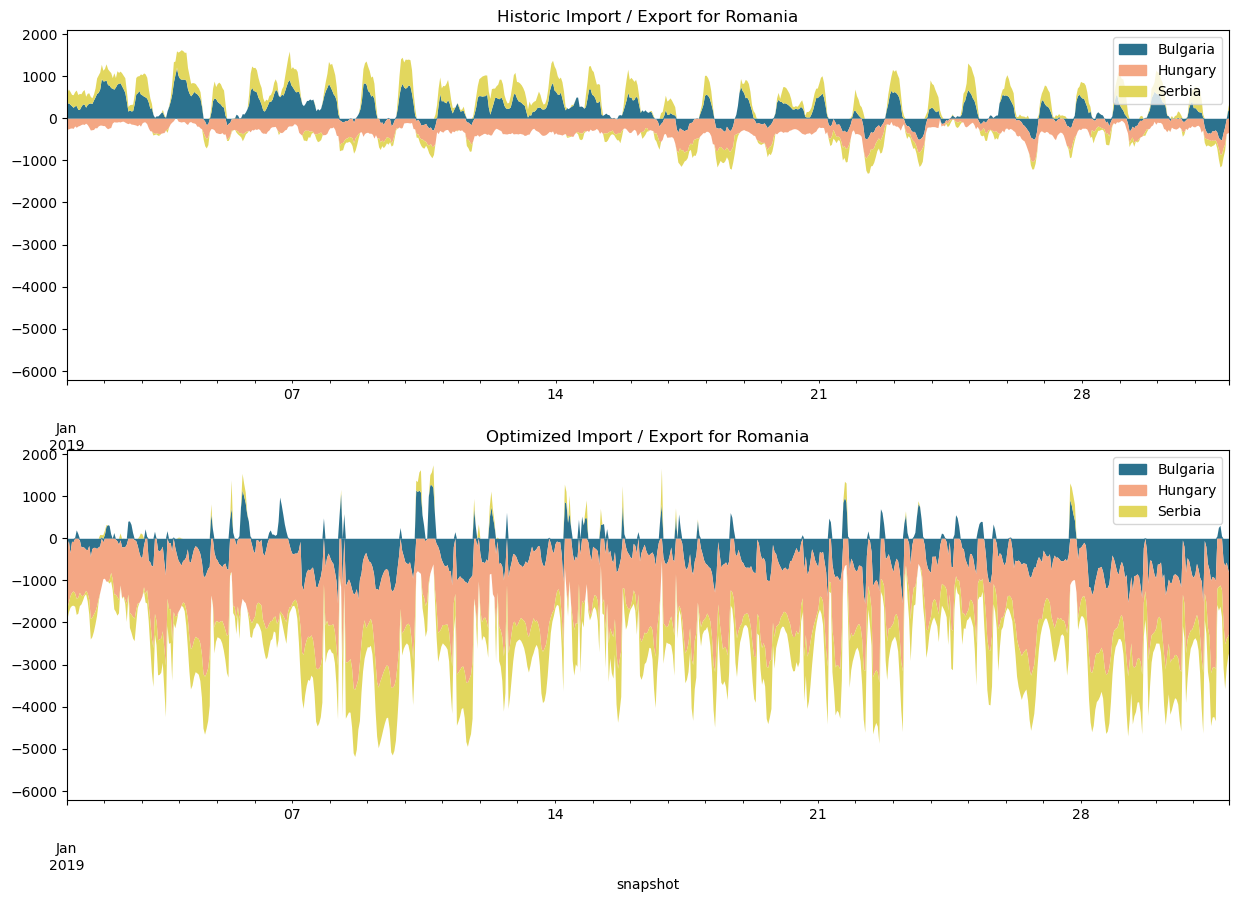

In [ ]:
for country in all_country:
    cross_border_time_series(country,[historic,optimized],['Historic','Optimized'])